In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
#import csv
import sys as sys
from numpy import array
from numpy import argmax
from operator import itemgetter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from collections import defaultdict

torch.manual_seed(1)

In [2]:
def remove_single_actions(df):
  df = df.drop(df[(df['action_type'] == "clickout item") & (df['step'] == 1)].index)
  return df
  
def remove_test_single_actions(df_test, df_gt):
  df_sessions = df_test.groupby('session_id')

  for group_name, df_group in df_sessions:
    session_len = 0

    for action_index, action in df_group.iterrows():
      session_len = session_len + 1
    
    if session_len == 1:
      df_test = df_test.drop(df_test[df_test['session_id'] == action['session_id']].index)
      df_gt = df_gt.drop(df_gt[df_gt['session_id'] == action['session_id']].index)
      #df = df.drop(df[(df['action_type'] == "clickout item") & (df['step'] == 1)].index)
    
  return df_test, df_gt  
  
def remove_nonitem_actions(df):
  df = df.drop(df[(df['action_type'] != 'interaction item image') & (df['action_type'] != 'interaction item deals') & (df['action_type'] != 'clickout item') & (df['action_type'] != 'search for item')].index)
  return df

def reduce_df(df, dim):
  df = df.head(dim)
  return pd.DataFrame(df)

def get_corpus(df):
  session_id = ''
  temp_session = []
  splitted_sessions = []
  impressions = []

  for action_index, action in df.iterrows():
    if session_id == '':
      session_id = action['session_id']

    if session_id != action['session_id']:
      splitted_sessions.append(temp_session)
      splitted_sessions = splitted_sessions + impressions
      temp_session = []
      impressions = []

    temp_session.append(action['reference'])
    session_id = action['session_id']
    
    if action['action_type'] == 'clickout item':
      impressions.append(action['impressions'].split('|')[:8])
      

  return splitted_sessions

def generate_prices_sparse_matrix(df, features_col='intervals'):
    df['present'] = 1
    hotel_dict = create_item_dict(df) #Controllare che sia uguale all'altro dizionario
    feature_dict = create_item_dict(df, col_name='feature')
    list_hotel = list(df['reference'])
    list_features = list(df['feature'])
    list_data = list(df['present'])
    n_items = len(list_hotel)
    n_features = len(list_features)
    # Convert each list of string in a list of indexes
    list_items = list(map(lambda x: hotel_dict[x], list_hotel))
    list_features = list(map(lambda x: feature_dict[x], list_features))
    # Generate the sparse matrix
    row = np.array(list_items)
    col = np.array(list_features)
    data = np.array(list_data)
    csr = csr_matrix((data, (row, col)), shape=(n_items, n_features))

    return csr, hotel_dict
  
def get_hotel_prices(df_metadata, n_categories = 2000):
    """
    Required Input -
        - metadata_file = file with the average price for each hotel
    """
    #print("Reading metadata: " + metadata_file)
    df_metadata['price'] = df_metadata['price'].apply(lambda x: math.log10(x))
    # Define the range
    max_price = df_metadata['price'].max()
    min_price = df_metadata['price'].min()
    range = (max_price - min_price) / n_categories
    # Generate the classes
    df_metadata['intervals'] = pd.cut(df_metadata['price'], bins=np.arange(min_price,max_price,range))
    df_metadata.loc[:, 'intervals'] = df_metadata['intervals'].apply(str)
    #classes_dic = create_user_dict(df_metadata, col_name = 'intervals')
    #df_metadata.loc[:, 'intervals'] = df_metadata['intervals'].apply(lambda x : classes_dic.get(x))
    #df_metadata.loc[:, 'intervals'] = df_metadata['intervals'].apply(int)
    # Create a dictionary of item_id -> price_category
    price_dic = pd.Series(df_metadata.intervals.values,index=df_metadata.impressions).to_dict()


    return price_dic

In [3]:
df_encode = pd.read_csv("./encode_1.csv")
df_encode = remove_single_actions(df_encode)
df_encode = remove_nonitem_actions(df_encode)

In [4]:
len(df_encode)

133689

In [5]:
#df_encode = reduce_df(df_encode, 80000)

In [6]:
df_train = pd.read_csv("./train_1.csv")
df_train = remove_single_actions(df_train)
df_train =  remove_nonitem_actions(df_train)

In [7]:
#df_train = reduce_df(df_train, 10000)

In [8]:
df_test = pd.read_csv("./test_1.csv")
df_test = remove_single_actions(df_test)
df_test = remove_nonitem_actions(df_test)

In [9]:
#df_test = reduce_df(df_test, 1000)

In [10]:
df_gt = pd.read_csv("./gt_1.csv")

In [11]:
#df_gt = reduce_df(df_gt, 1000)

In [12]:
df_test, df_gt = remove_test_single_actions(df_test, df_gt)

In [13]:
df_meta = pd.read_csv("./item_metadata.csv")

In [14]:
df_prices = pd.read_csv("./hotel_prices.csv")

In [15]:
price_dict = get_hotel_prices(df_prices, n_categories = 100)

In [16]:
len(list(set(price_dict.values())))

100

In [17]:
corpus = get_corpus(df_encode)

gensim trial

In [18]:
from gensim.models import Word2Vec

In [19]:
def normalize_word2vec(word2vec):
  hotels_pre_norm = []

  for hotel in word2vec.wv.index2word:
    hotels_pre_norm.append(word2vec.wv[hotel].tolist())

  hotels_pre_norm = np.asarray(hotels_pre_norm)
  hotels_post_norm = normalize(hotels_pre_norm, norm='l2', axis=0, copy=True, return_norm=False)
  
  hotels_post_norm = hotels_post_norm.tolist()

  for hotel in word2vec.wv.index2word:
    word2vec.wv[hotel] = np.asarray(hotels_post_norm[0])
    hotels_post_norm.pop(0)
    
  return word2vec

In [20]:
word2vec = Word2Vec(corpus, min_count=1, window=3, sg=1) 

In [21]:
n_features = len(word2vec.wv['666856'])
n_features

100

In [22]:
word2vec.wv['666856']

array([-0.09708571,  0.01450443,  0.01949274,  0.03897639, -0.04913339,
       -0.04498722,  0.09986436, -0.07522274,  0.01510935,  0.03044846,
        0.10778463,  0.00694289, -0.01273461,  0.0971311 ,  0.08686747,
       -0.110892  ,  0.03354829, -0.10877705,  0.02328673,  0.0092564 ,
        0.00065245, -0.08706087,  0.03900485,  0.03423278,  0.02327186,
        0.01050502, -0.04119699, -0.13270745, -0.00690384,  0.17873171,
       -0.1770882 , -0.14141908,  0.04149662,  0.10520889,  0.17158365,
        0.00150524,  0.06818271, -0.10828871,  0.05490722,  0.0392887 ,
       -0.01701277, -0.03850885,  0.00836383, -0.01262134,  0.00777675,
       -0.08829135,  0.07313978, -0.02685392,  0.00893236, -0.034555  ,
       -0.00586099, -0.07758086,  0.04530589,  0.01156741, -0.01113276,
       -0.09226864,  0.0385459 ,  0.03921487,  0.11916353, -0.04591211,
       -0.01738619,  0.10533518, -0.08699502, -0.02547752, -0.0346681 ,
        0.05414008,  0.01160146, -0.00637647,  0.04928969,  0.01

In [23]:
word2vec.wv.most_similar(positive = '4102552')

[('5502296', 0.9906396865844727),
 ('880913', 0.9892023205757141),
 ('12750', 0.9891103506088257),
 ('44219', 0.9889092445373535),
 ('22534', 0.9888982176780701),
 ('922625', 0.9887827634811401),
 ('2880248', 0.9885542392730713),
 ('76400', 0.98833829164505),
 ('9599992', 0.9883348941802979),
 ('131100', 0.9883331060409546)]

In [24]:
#hotel_dict = normalize_word2vec(word2vec.wv)
hotel_dict = word2vec.wv

In [25]:
word2vec.wv['666856']

array([-0.09708571,  0.01450443,  0.01949274,  0.03897639, -0.04913339,
       -0.04498722,  0.09986436, -0.07522274,  0.01510935,  0.03044846,
        0.10778463,  0.00694289, -0.01273461,  0.0971311 ,  0.08686747,
       -0.110892  ,  0.03354829, -0.10877705,  0.02328673,  0.0092564 ,
        0.00065245, -0.08706087,  0.03900485,  0.03423278,  0.02327186,
        0.01050502, -0.04119699, -0.13270745, -0.00690384,  0.17873171,
       -0.1770882 , -0.14141908,  0.04149662,  0.10520889,  0.17158365,
        0.00150524,  0.06818271, -0.10828871,  0.05490722,  0.0392887 ,
       -0.01701277, -0.03850885,  0.00836383, -0.01262134,  0.00777675,
       -0.08829135,  0.07313978, -0.02685392,  0.00893236, -0.034555  ,
       -0.00586099, -0.07758086,  0.04530589,  0.01156741, -0.01113276,
       -0.09226864,  0.0385459 ,  0.03921487,  0.11916353, -0.04591211,
       -0.01738619,  0.10533518, -0.08699502, -0.02547752, -0.0346681 ,
        0.05414008,  0.01160146, -0.00637647,  0.04928969,  0.01

In [26]:
#preparing training data

#gets the training set and splits it in subsessions populated by the item of the action
def prepare_input(df_train):
  training_set = []
  category_set = []
  hotels_window_set = []
  
  df_sessions = df_train.groupby('session_id')

  for group_name, df_group in df_sessions:
    sub_sessions = []
    categories = []
    temp_session = []
    hotels_window = []

    for action_index, action in df_group.iterrows():
      if action['action_type'] == 'clickout item':
        sub_sessions.append(temp_session)
        temp_session.append(action)
        categories.append(action['reference'])
        hotels_window.append(action['impressions'].split('|'))
      else:
        temp_session.append(action)
        
    #training_set.concatenate(sub_sessions)
    #category_set.concatenate(categories)
    #hotels_window_set.concatenate(hotels_window)
    #training_set = training_set + sub_sessions
    #category_set = category_set + categories
    #hotels_window_set = hotels_window_set + hotels_window
    if(len(sub_sessions) != 0):
        training_set.append(sub_sessions[-1])
        category_set.append(categories[-1])
        hotels_window_set.append(hotels_window[-1])
    
  return training_set, category_set, hotels_window_set

#gets the training set and splits it in subsessions populated by the item of the action
def prepare_input_batched(df_train, batch_size):
  training_set = []
  category_set = []
  hotels_window_set = []

  training_set_batched = []
  category_set_batched = []
  hotels_window_set_batched = []

  df_sessions = df_train.groupby('session_id')

  for group_name, df_group in df_sessions:
    sub_sessions = []
    categories = []
    temp_session = []
    hotels_window = []

    for action_index, action in df_group.iterrows():
      if action['action_type'] == 'clickout item':
        sub_sessions.append(temp_session)
        temp_session.append(action)
        categories.append(action['reference'])
        hotels_window.append(action['impressions'].split('|'))
      else:
        temp_session.append(action)
        
    #training_set.concatenate(sub_sessions)
    #category_set.concatenate(categories)
    #hotels_window_set.concatenate(hotels_window)
    #training_set = training_set + sub_sessions
    #category_set = category_set + categories
    #hotels_window_set = hotels_window_set + hotels_window
    if(len(sub_sessions) != 0):
        training_set.append(sub_sessions[-1])
        category_set.append(categories[-1])
        hotels_window_set.append(hotels_window[-1])
  
  temp_session_batched = []
  temp_category_batched = []
  temp_hotel_window_batched = []
  
  for si, session in enumerate(training_set):
    temp_session_batched.append(session)
    temp_category_batched.append(category_set[si])
    temp_hotel_window_batched.append(hotels_window_set[si])
  
    if len(temp_session_batched) == batch_size:
      training_set_batched.append(temp_session_batched)
      category_set_batched.append(temp_category_batched)
      hotels_window_set_batched.append(temp_hotel_window_batched)
      temp_session_batched = []
      temp_category_batched = []
      temp_hotel_window_batched = []

  if len(temp_session_batched) != 0:
    training_set_batched.append(temp_session_batched)
    category_set_batched.append(temp_category_batched)
    hotels_window_set_batched.append(temp_hotel_window_batched)
    
    
  return training_set_batched, category_set_batched, hotels_window_set_batched

def prepare_test(df_test, df_gt):
  #Creating a NaN column for item recommendations
  df_test['item_recommendations'] = np.nan

  test_dim = len(df_test)

  temp_session = []
  test_sessions = []

  temp_clickout_index = []
  test_clickout_index = []

  temp_hotels_window = []
  test_hotels_window = []

  i = 0
  step = 0

  #splitting in sessions while evaluating recommendations for NaN clickouts
  for action_index, action in df_test.iterrows():
      if(action['reference'] != 'unknown'):
          if (action['action_type'] == 'clickout item') & math.isnan(float(action['reference'])):
              temp_hotels_window = action['impressions'].split('|')
              temp_session.append(action)
              temp_clickout_index.append(action_index)
          else:
              temp_session.append(action)

      if(i < test_dim-1):
          if action['session_id'] != df_test.iloc[[i + 1]]['session_id'].values[0]:
              step = 0
              test_sessions.append(temp_session)
              test_hotels_window.append(temp_hotels_window)
              test_clickout_index.append(temp_clickout_index)
              temp_session = []
              temp_hotels_window = []
              temp_clickout_index = []


      i = i+1  
      step = step + 1
        
  return test_sessions, test_hotels_window, test_clickout_index
        

In [27]:
def recommendations_from_output(output, hotel_dict, hotels_window, n_features):
  i = 0
  window_dict = {}
  
  output_arr = np.asarray(output[0].cpu().detach().numpy())
    
  ranked_hotels = {}
  
  #for hotel_k, hotel_t in window_dict.items():
  #  d = distance(output, hotel_t)
  #  ranked_hotels[hotel_k] = d
  
  #hotel_scores = {}
  hotel_i = 0
  missed = 0
  #print(len(output_arr))
  
  for hotel_v in output_arr:
    #print(hotel_v)
    hotel_id = hotel_dict.index2word[hotel_i]
    #print(hotel_id)
    #print(hotel_id)
    #print(hotels_window)
    if hotel_id in hotels_window:
      #print('found')
      ranked_hotels[hotel_id] = hotel_v
    hotel_i = hotel_i + 1
  
  for hotel_id in hotels_window:
    if hotel_id not in ranked_hotels:
      ranked_hotels[hotel_id] = -999999
      #print(hotel_id)
      missed = missed + 1
  #print(str(len(hotels_window)) + ' - ' + str(missed))

  #ranked_hotels = sorted(ranked_hotels)
  ranked_hotels = sorted(ranked_hotels.items(), key=itemgetter(1), reverse = True)
  #print(ranked_hotels)
  #print(hotels_window)
  #print(ranked_hotels)
  #print(list_to_space_string(ranked_hotels))
  ranked = []
  for tup in ranked_hotels:
    ranked.append(tup[0])
    
  #print(ranked_hotels)
                           
                           
  return list_to_space_string(ranked)


# Just return an output given a line
def evaluate(session, hotel_dict, n_features, hotels_window, max_window):
    #hidden = rnn.initHidden()
    hidden = torch.zeros(1, 1, n_hidden)
    c = torch.zeros(1, 1, n_hidden)
    
    #print(session)
    #print(max_window)
    line_tensor = session_to_tensor(session, hotels_window, max_window).cuda()
    
    output = model(line_tensor)
        
    #print(output)
    output = recommendations_from_output(output, hotel_dict, hotels_window, n_features)

    return output
  
  
def recommendations_from_output_debug(output, hotel_dict, hotels_window, n_features):
  i = 0
  window_dict = {}
  
  output_arr = np.asarray(output[0].cpu().detach().numpy())
    
  ranked_hotels = {}
  
  #for hotel_k, hotel_t in window_dict.items():
  #  d = distance(output, hotel_t)
  #  ranked_hotels[hotel_k] = d
  
  #hotel_scores = {}
  hotel_i = 0
  
  print(len(output_arr))
  print(hotels_window)
  
  for hotel_index, hotel_v in enumerate(output_arr):
    #print(hotel_v)
    hotel_id = hotel_dict.index2word[hotel_index]
    #print(hotel_id)
    #print(hotel_id)
    #print(hotels_window)
    if hotel_id in hotels_window:
      #print('found')
      ranked_hotels[hotel_id] = hotel_v
    hotel_i = hotel_i + 1
  
  for hotel_id in hotels_window:
    if hotel_id not in ranked_hotels:
      ranked_hotels[hotel_id] = -999999
      print('cant find ' + str(i) + ' sessions')
  
  #ranked_hotels = sorted(ranked_hotels)
  ranked_hotels = sorted(ranked_hotels.items(), key=itemgetter(1), reverse = True)
  #print(ranked_hotels)
  #print(hotels_window)
  #print(ranked_hotels)
  #print(list_to_space_string(ranked_hotels))
  ranked = []
  for tup in ranked_hotels:
    ranked.append(tup[0])
    
  print(ranked_hotels)
                           
                           
  return list_to_space_string(ranked)
  
def evaluate_debug(session, hotel_dict, n_features, hotels_window, max_window):
    #hidden = rnn.initHidden()
    hidden = torch.zeros(1, 1, n_hidden)
    c = torch.zeros(1, 1, n_hidden)
    
    #print(session)
    #print(max_window)
    line_tensor = session_to_tensor(session, hotels_window, max_window).cuda()
    #print(line_tensor)

    output = model(line_tensor)
        
    print(output)
    output = recommendations_from_output_debug(output, hotel_dict, hotels_window, n_features)

    return output
  
def recommendations_from_output_debug_false(output, hotel_dict, hotels_window, n_features):
  i = 0
  window_dict = {}
  
  output_arr = np.asarray(output[0].cpu().detach().numpy())
    
  ranked_hotels = {}
  
  #for hotel_k, hotel_t in window_dict.items():
  #  d = distance(output, hotel_t)
  #  ranked_hotels[hotel_k] = d
  
  #hotel_scores = {}
  hotel_i = 0
  
  print(len(output_arr))
  print(hotels_window)
  
  for hotel_index, hotel_v in enumerate(output_arr):
    #print(hotel_v)
    hotel_id = hotel_dict.index2word[hotel_index]
    #print(hotel_id)
    #print(hotel_id)
    #print(hotels_window)
    if hotel_id in hotels_window:
      #print('found')
      ranked_hotels[hotel_id] = hotel_v
    hotel_i = hotel_i + 1
  
  for hotel_id in hotels_window:
    if hotel_id not in ranked_hotels:
      ranked_hotels[hotel_id] = 0
      #print('cant find ' + str(i) + ' sessions')
  
  #ranked_hotels = sorted(ranked_hotels)
  ranked_hotels = sorted(ranked_hotels.items(), key=itemgetter(1), reverse = False)
  #print(ranked_hotels)
  #print(hotels_window)
  #print(ranked_hotels)
  #print(list_to_space_string(ranked_hotels))
  ranked = []
  for tup in ranked_hotels:
    ranked.append(tup[0])
    
  print(ranked_hotels)
                           
                           
  return list_to_space_string(ranked)
  
def evaluate_debug_false(session, hotel_dict, n_features, hotels_window, max_window):
    #hidden = rnn.initHidden()
    hidden = torch.zeros(1, 1, n_hidden)
    c = torch.zeros(1, 1, n_hidden)
    
    #print(session)
    #print(max_window)
    line_tensor = session_to_tensor(session, hotels_window, max_window).cuda()
    output = model(line_tensor)
        
    print(output)
    output = recommendations_from_output_debug_false(output, hotel_dict, hotels_window, n_features)

    return output
  
def get_submission_target(df):
    """Identify target rows with missing click outs."""

    mask = df["reference"].isnull() & (df["action_type"] == "clickout item")
    df_out = df[mask]

    return df_out  

def get_reciprocal_ranks(ps):
    """Calculate reciprocal ranks for recommendations."""
    mask = ps.reference == np.array(ps.item_recommendations)

    if mask.sum() == 1:
        rranks = generate_rranks_range(0, len(ps.item_recommendations))
        return np.array(rranks)[mask].min()
    else:
        return 0.0


def score_submissions(subm_csv, gt_csv, objective_function):
    """Score submissions with given objective function."""

    print(f"Reading ground truth data {gt_csv} ...")
    df_gt = read_into_df(gt_csv)

    print(f"Reading submission data {subm_csv} ...")
    df_subm = read_into_df(subm_csv)

    # create dataframe containing the ground truth to target rows
    cols = ['reference', 'impressions', 'prices']
    df_key = df_gt.loc[:, cols]

    # append key to submission file
    df_subm_with_key = df_key.join(df_subm, how='inner')
    df_subm_with_key.reference = df_subm_with_key.reference.astype(int)
    df_subm_with_key = convert_string_to_list(
        df_subm_with_key, 'item_recommendations', 'item_recommendations'
    )

    # score each row
    df_subm_with_key['score'] = df_subm_with_key.apply(objective_function, axis=1)
    mrr = df_subm_with_key.score.mean()

    return mrr
  
def generate_rranks_range(start, end):
    """Generate reciprocal ranks for a given list length."""

    return 1.0 / (np.arange(start, end) + 1)
  
def convert_string_to_list(df, col, new_col):
    """Convert column from string to list format."""
    fxn = lambda arr_string: [int(item) for item in str(arr_string).split(" ")]

    mask = ~(df[col].isnull())

    df[new_col] = df[col]
    df.loc[mask, new_col] = df[mask][col].map(fxn)

    return df


def get_reciprocal_ranks(ps):
    """Calculate reciprocal ranks for recommendations."""
    mask = ps.reference == np.array(ps.item_recommendations)

    if mask.sum() == 1:
        rranks = generate_rranks_range(0, len(ps.item_recommendations))
        return np.array(rranks)[mask].min()
    else:
        return 0.0
  

def score_submissions_no_csv(df_subm, df_gt, objective_function):
    # create dataframe containing the ground truth to target rows
    cols = ['reference', 'impressions', 'prices']
    df_key = df_gt.loc[:, cols]

    # append key to submission file
    df_subm_with_key = df_key.join(df_subm, how='inner')
    df_subm_with_key.reference = df_subm_with_key.reference.astype(int)
    df_subm_with_key = convert_string_to_list(
        df_subm_with_key, 'item_recommendations', 'item_recommendations'
    )

    # score each row
    df_subm_with_key['score'] = df_subm_with_key.apply(objective_function, axis=1)
    mrr = df_subm_with_key.score.mean()

    return mrr
  
  
def test_accuracy(model, df_test, df_gt):
  df_test['item_recommendations'] = np.nan

  test_dim = len(df_test)
  temp_session = []
  hotels_window = []
  i = 0
  print_every = 500
  step = 0
  #df_result = pd.DataFrame(index = [0], columns=df_test.columns)
  #print(df_result)

  for action_index, action in df_test.iterrows():

    #print(action)
    #print('step ' + str(step))
    #print(len(temp_session)) 
    if(action['reference'] != 'unknown'):
      if (action['action_type'] == 'clickout item') & math.isnan(float(action['reference'])):
        hotels_window = action['impressions'].split('|')

        #print('window is ' + str(hotels_window))
        #print(len(temp_session)) 

        if len(temp_session) != 0:
          #print('doing sub')
          #print(evaluate(temp_session, hotel_dict, n_features, hotels_window, distance))
          df_test.loc[action_index, 'item_recommendations'] = evaluate(temp_session, hotel_dict, n_features, hotels_window, max_window)
        #print(p.o)
        temp_session.append(action)
        #print('added click')
      else:
        temp_session.append(action)
        #print(temp_session)
        #print('added action')

    if(i < test_dim-1):
      if action['session_id'] != df_test.iloc[[i + 1]]['session_id'].values[0]:
        step = 0
        #print(temp_session)
        #print(hotels_window)
        #print(p.r)
        temp_session = []
        hotels_window = []

    i = i+1  
    step = step + 1
    
    
  df_sub = get_submission_target(df_test)
  df_sub = df_sub[['user_id', 'session_id', 'timestamp','step', 'item_recommendations']]
  
  for action_index, action in df_gt.iterrows():
    if action_index not in df_sub.index.values.tolist():
      df_gt = df_gt.drop(action_index)

  mask = df_sub["item_recommendations"].notnull()
  df_sub = df_sub[mask]
  
  mrr = score_submissions_no_csv(df_sub, df_gt, get_reciprocal_ranks)
  return mrr

def test_accuracy_optimized(model, df_test, df_gt, sessions, hotels_window, clickout_index, hotel_dict, n_features, max_window, meta_dict, meta_list, subname="submission_default_name", isprint=False):
  """Return the score obtained by the net on the test dataframe"""

  test_dim = len(df_test)

  print_every = 500
  
  missed_target = 0

  for session_index, session in enumerate(sessions):
    if clickout_index[session_index] != []:
      df_test.loc[clickout_index[session_index], 'item_recommendations'] = evaluate(session, hotel_dict, n_features, hotels_window[session_index], max_window)
      #print(df_gt[(df_gt['session_id'] == df_test.loc[clickout_index[session_index], 'session_id'].values[0]) & (df_gt['step'] == df_test.loc[clickout_index[session_index], 'step'].values[0])]['reference'].values[0])
      #target = df_gt[(df_gt['session_id'] == df_test.loc[clickout_index[session_index], 'session_id'].values[0]) & (df_gt['step'] == df_test.loc[clickout_index[session_index], 'step'].values[0])]['reference'].values[0]
      #print(type(target))
      #if int(target) not in hotel_dict: 
        #missed_target = missed_target + 1
        #print(session_index)
  df_sub = get_submission_target(df_test)

  print(str(missed_target) + ' correct hotels were not in dictionary - total: ' + str(len(hotels_window)))
  
  #Removing unnecessary columns
  df_sub = df_sub[['user_id', 'session_id', 'timestamp','step', 'item_recommendations']]

  mask = df_sub["item_recommendations"].notnull()
  df_sub = df_sub[mask]

  # Saving df_sub
  if isprint:
      df_sub.to_csv('./' + subname + '.csv')

  mrr = score_submissions_no_csv(df_sub, df_gt, get_reciprocal_ranks)
  return mrr


def test_accuracy_optimized_false(model, df_test, df_gt, sessions, hotels_window, clickout_index, hotel_dict, n_features, max_window, meta_dict, meta_list, subname="submission_default_name", isprint=False):
  """Return the score obtained by the net on the test dataframe"""

  test_dim = len(df_test)

  print_every = 500


  for session_index, session in enumerate(sessions):
    if clickout_index[session_index] != []:
      df_test.loc[clickout_index[session_index], 'item_recommendations'] = evaluate_debug_false(session, hotel_dict, n_features, hotels_window[session_index], max_window)
      #print(session_index)
  df_sub = get_submission_target(df_test)

  #Removing unnecessary columns
  df_sub = df_sub[['user_id', 'session_id', 'timestamp','step', 'item_recommendations']]

  mask = df_sub["item_recommendations"].notnull()
  df_sub = df_sub[mask]

  # Saving df_sub
  if isprint:
      df_sub.to_csv('./' + subname + '.csv')

  mrr = score_submissions_no_csv(df_sub, df_gt, get_reciprocal_ranks)
  return mrr

In [28]:
#acc = test_accuracy_optimized(model, df_test, df_gt, test_sessions, test_hotels_window, test_clickout_index, hotel_dict, n_features, max_window, meta_dict, meta_list)

1

In [29]:

'''
STEP 3: CREATE MODEL CLASS
'''
 
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
         
        # Number of hidden layers
        self.layer_dim = layer_dim
               
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = layer_dim)  
        
        #self.gru = nn.GRU(input_size = input_dim, hidden_size = hidden_dim, num_layers = layer_dim, dropout = 0.2)
        
        self.hidden_fc = nn.Linear(hidden_dim, hidden_dim * 20)
        
        #self.hidden_fc2 = nn.Linear(hidden_dim * 10, hidden_dim * 100)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.dropout_layer = nn.Dropout(p=0.2)
        
        self.softmax = nn.LogSoftmax(1)
    
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        #print(x.shape,"x.shape")100, 28, 28
        if torch.cuda.is_available():
            h0 = torch.zeros(self.layer_dim, x.size(1), self.hidden_dim).cuda()
        else:
            h0 = torch.zeros(self.layer_dim, x.size(1), self.hidden_dim)

        # Initialize cell state
        if torch.cuda.is_available():
            c0 = torch.zeros(self.layer_dim, x.size(1), self.hidden_dim).cuda()
        else:
            c0 = torch.zeros(self.layer_dim, x.size(1), hidden_dim)

        
        #cn = c0[0,:,:]
        #hn = h0[0,:,:]

        #for seq in range(x.size(1)):
        #    hn, cn = self.lstm(x[:,seq,:], (hn,cn)) 
        #    outs.append(hn)
            
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        #out, hn = self.gru(x, h0.detach())
        
        #out = self.fc(out)
        
        out = out[-1, :, :]
        
        #out = F.relu(self.hidden_fc(out))
        
        #out = F.relu(self.hidden_fc2(out))
        
        #out = self.dropout_layer(out)
       
        
        #out = out[]
        
        out = self.fc(out)
        
        #out = self.softmax(out)
        
        #out = self.fc(out) 
        # out.size() --> 100, 10
        return out

In [30]:
batchsize = 16

In [31]:
if batchsize == 0:
    #this splits the training set sessions into multiple mini-sessions
    sessions, categories, hotels_window = prepare_input(df_train)
else:
    sessions, categories, hotels_window = prepare_input_batched(df_train, batchsize)

In [32]:
test_sessions, test_hotels_window, test_clickout_index = prepare_test(df_test, df_gt)

In [33]:
max_window = 0
for window in hotels_window:
  if len(window) > max_window:
    max_window = len(window)
for window in test_hotels_window:
  if len(window) > max_window:
    max_window = len(window)
max_window = 25

In [34]:
meta_dict = []
meta_list = []
price_dict = []
n_hotels = len(hotel_dict.index2word)
n_features_w2vec = len(word2vec.wv['666856'])
n_features_impression = max_window
n_features_prices = 0
n_features = n_features_w2vec + n_features_impression + n_features_prices

print('n_hotels is ' + str(n_hotels))
print('n_features_w2vec is ' + str(n_features_w2vec))
print('n_features_impression is ' + str(n_features_impression))
print('n_features_prices is ' + str(n_features_prices))
print('n_features is ' + str(n_features))

n_hotels is 14656
n_features_w2vec is 100
n_features_impression is 0
n_features_prices is 0
n_features is 100


In [35]:
input_dim = n_features
output_dim = n_hotels
#hidden_dim = int(1/10 * (input_dim + output_dim))
hidden_dim = 100
print('hidden_dim is ' + str(hidden_dim))
layer_dim = 1
n_hidden = hidden_dim

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
model.lstm.weight_hh_l0.data.fill_(0)
x = 1
nn.init.uniform_(model.fc.weight, -x, x)
nn.init.uniform_(model.fc.bias, -x, x)
model = model.cuda()

hidden_dim is 100


In [36]:
#functions for training phase

def session_to_tensor(session, hotels_window, max_window):
  tensor = torch.zeros(len(session), 1, n_features)
  
  for ai, action in enumerate(session):
    tensor[ai][0] = hotel_to_tensor(action['reference'], hotel_dict, n_features_w2vec, hotels_window, max_window)
  return tensor

def sessions_to_batch(session_list, hotel_dict, max_session_len, batch_size, n_features, n_features_w2vec, hotels_window, max_window): #modified

  tensor = torch.zeros(max_session_len, batch_size, n_features)
  
  for si, session in enumerate(session_list):
    for ai, action in enumerate(session):
      tensor[ai][si] = hotel_to_tensor(action['reference'], hotel_dict, n_features_w2vec, hotels_window, max_window)
  return tensor

def hotel_to_tensor(hotel, hotel_dict, n_features_w2vec, hotels_window, max_window):
  tensor_w2vec = torch.zeros(n_features_w2vec)
  tensor_window = torch.zeros(max_window)
  tensor_prices = torch.zeros(n_features_prices)
  
  if hotel in hotel_dict: #-----------int
    tensor_w2vec = torch.from_numpy(hotel_dict[hotel])
  
  if max_window != 0:
    if hotel in hotels_window:
      tensor_window[hotels_window.index(hotel)] = 1
    
  if hotel in price_dict:
    tensor_prices[price_dict.index(hotel)] = 1
      
  tensor = torch.cat((tensor_w2vec, tensor_window), 0)
  tensor = torch.cat((tensor, tensor_prices), 0)
  
  return tensor

def hotel_to_category(hotel, hotel_dict, n_features):
  tensor = torch.zeros(1)

  if hotel in hotel_dict.index2word:
    tensor = torch.tensor([hotel_dict.index2word.index(hotel)], dtype=torch.long)

  
  return tensor

def hotels_to_category_batch(hotel_list, hotel_dict, n_hotels, batch_size): #modified
  tensor = torch.zeros(batch_size)
  for hi, hotel in enumerate(hotel_list):
    if hotel in hotel_dict.index2word:
      tensor[hi] = torch.tensor([hotel_dict.index2word.index(hotel)], dtype=torch.long)
  return tensor

In [37]:
def category_from_output(output):
  top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
  category_i = int(top_i[0][0])
  #print(output)
  return hotel_dict.index2word[category_i], category_i
  
  
def list_to_space_string(l):
  """Return a space separated string from a list"""
  s = " ".join(l)
  return s

In [5]:
def bpr_loss(positive_predictions, negative_predictions, mask=None):
    """
    Bayesian Personalised Ranking [1]_ pairwise loss function.

    Parameters
    ----------

    positive_predictions: tensor
        Tensor containing predictions for known positive items.
    negative_predictions: tensor
        Tensor containing predictions for sampled negative items.
    mask: tensor, optional
        A binary tensor used to zero the loss from some entries
        of the loss tensor.

    Returns
    -------

    loss, float
        The mean value of the loss function.

    References
    ----------

    .. [1] Rendle, Steffen, et al. "BPR: Bayesian personalized ranking from
       implicit feedback." Proceedings of the twenty-fifth conference on
       uncertainty in artificial intelligence. AUAI Press, 2009.
    """

    loss = (1.0 - F.sigmoid(positive_predictions -
                            negative_predictions))

    if mask is not None:
        mask = mask.float()
        loss = loss * mask
        return loss.sum() / mask.sum()

    return loss.mean()

In [9]:
#loss_fn = torch.nn.CrossEntropyLoss().cuda()
#loss_fn = torch.nn.NLLLoss().cuda()
loss_fn = bpr_loss

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    hidden = torch.zeros(1, 1, n_hidden)
    c = torch.zeros(1, 1, n_hidden)
    
    optimizer.zero_grad()
    
    line_tensor = line_tensor.requires_grad_()
    line_tensor = line_tensor.cuda()
    

    output = model(line_tensor)
    
    category_tensor = category_tensor.long().cuda()

    loss = loss_fn(category_tensor, category_tensor)
    loss.backward()

    optimizer.step()
    
    return output, loss.item()

NameError: name 'torch' is not defined

In [39]:
import time
import math

#distance = nn.PairwiseDistance(p=2., eps=1e-6)

num_epochs = 20

n_iters = len(sessions) * num_epochs
print_every = 100
plot_every = 1


# Keep track of losses for plotting
current_loss = 0
all_losses = []
all_acc = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, num_epochs + 1):
  model.train()
  iter = 0
  
  #print('epoch ' + str(epoch))
  print(str(len(sessions)) + ' sessions to be computed')
  
  for index, session in enumerate(sessions):
    iter = iter + 1

    #ession_tensor = session_to_tensor(session, hotels_window[index], max_window)
    #ategory = categories[index]
    #ategory_tensor = hotel_to_category(category, hotel_dict, n_hotels)

    if batchsize == 0:
        session_tensor = session_to_tensor(session, hotel_dict, n_features, n_features_w2vec, hotels_window[index], max_window)  
        category = categories[index]
        category_tensor = hotel_to_category(category, hotel_dict, n_hotels)
    else:
        max_session_len = 0
        for si, single_session in enumerate(session):
            if len(single_session) > max_session_len:
                max_session_len = len(single_session)
        session_tensor = sessions_to_batch(session, hotel_dict, max_session_len, batchsize, n_features, n_features_w2vec, hotels_window[index], max_window)
        category = categories[index]
        category_tensor = hotels_to_category_batch(category, hotel_dict, n_hotels, batchsize)
    
    output, loss = train(category_tensor, session_tensor)

    current_loss += loss
      
    if iter % print_every == 0:

        guess, guess_i = category_from_output(output)

        correct = '✓' if guess == category else '✗ (%s)' % category
        #print('(%s) %.4f %s / %s %s' % (timeSince(start), loss, session[0][0]['session_id'], guess[0], correct[0]))

        
  # Add current loss avg to list of losses
  if epoch % plot_every == 0:
      all_losses.append(current_loss / (plot_every * len(sessions)))
      print('Epoch: ' + str(epoch) + ' Loss: ' + str(current_loss / (plot_every * len(sessions))))
      print('%d %d%% (%s)' % (epoch, epoch / num_epochs * 100, timeSince(start)))
      #acc = test_accuracy(model, df_test, df_gt)
      acc = test_accuracy_optimized(model, df_test, df_gt, test_sessions, test_hotels_window, test_clickout_index, hotel_dict, n_features, max_window, meta_dict, meta_list)
      print("Score: " + str(acc))
      all_acc.append(acc)
      current_loss = 0

612 sessions to be computed
Epoch: 1 Loss: 9.825105115479113
1 5% (0m 20s)
0 correct hotels were not in dictionary - total: 1088
Score: 0.39341247165430837
612 sessions to be computed
Epoch: 2 Loss: 9.1655078682245
2 10% (0m 47s)
0 correct hotels were not in dictionary - total: 1088
Score: 0.37507100289828194
612 sessions to be computed
Epoch: 3 Loss: 8.560413655891917
3 15% (1m 14s)
0 correct hotels were not in dictionary - total: 1088
Score: 0.3798606686756741
612 sessions to be computed
Epoch: 4 Loss: 8.440543738065982
4 20% (1m 39s)
0 correct hotels were not in dictionary - total: 1088
Score: 0.38265832161319707
612 sessions to be computed
Epoch: 5 Loss: 8.907572064524382
5 25% (2m 6s)
0 correct hotels were not in dictionary - total: 1088
Score: 0.3815897617232896
612 sessions to be computed
Epoch: 6 Loss: 8.852038277520073
6 30% (2m 33s)
0 correct hotels were not in dictionary - total: 1088
Score: 0.3885217398467933
612 sessions to be computed
Epoch: 7 Loss: 8.567467518881255
7 35

In [40]:
df_test

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,item_recommendations
1,02HGRBA06ODU,fa3a53156ae5c,1541030843,2,interaction item image,3377332,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
2,02HGRBA06ODU,fa3a53156ae5c,1541030843,3,interaction item image,3377332,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
5,02HGRBA06ODU,fa3a53156ae5c,1541030877,6,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
6,02HGRBA06ODU,fa3a53156ae5c,1541030877,7,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
7,02HGRBA06ODU,fa3a53156ae5c,1541030887,8,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
8,02HGRBA06ODU,fa3a53156ae5c,1541030887,9,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
9,02HGRBA06ODU,fa3a53156ae5c,1541030887,10,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
10,02HGRBA06ODU,fa3a53156ae5c,1541030897,11,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
11,02HGRBA06ODU,fa3a53156ae5c,1541030897,12,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
12,02HGRBA06ODU,fa3a53156ae5c,1541030897,13,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN


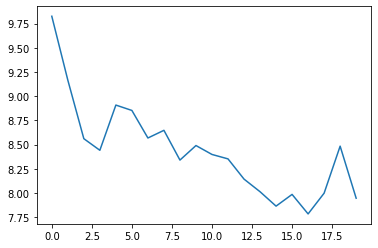

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

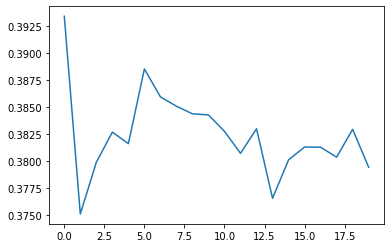

In [42]:
plt.figure()
plt.plot(all_acc)

In [43]:
test_hotels_window[5]

['8602',
 '8568',
 '8621',
 '8561',
 '57049',
 '8564',
 '8586',
 '8577',
 '8589',
 '55677',
 '77124',
 '148957',
 '893925',
 '1217148',
 '8588',
 '2793224',
 '8576',
 '1238070',
 '2282298',
 '32727',
 '8614',
 '73555',
 '567281',
 '1094242',
 '64376']

In [44]:
test_sessions[5]

[user_id                                                      0P3WZY097PQI
 session_id                                                  2423aea8cde50
 timestamp                                                      1541046141
 step                                                                    2
 action_type                                                 clickout item
 reference                                                            8563
 platform                                                               US
 city                                                       Las Vegas, USA
 device                                                             mobile
 current_filters                                                       NaN
 impressions             8621|77124|8624|2851635|488501|1810141|72285|8...
 prices                  1042|370|484|376|1031|871|228|310|255|202|193|...
 item_recommendations                                                  NaN
 Name: 215, dtype: object

In [45]:
df_test[df_test['session_id'] == '2423aea8cde50']

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,item_recommendations
215,0P3WZY097PQI,2423aea8cde50,1541046141,2,clickout item,8563,US,"Las Vegas, USA",mobile,NaN,8621|77124|8624|2851635|488501|1810141|72285|8...,1042|370|484|376|1031|871|228|310|255|202|193|...,NaN
217,0P3WZY097PQI,2423aea8cde50,1541046276,4,search for item,8602,US,"Las Vegas, USA",mobile,NaN,NaN,NaN,NaN
218,0P3WZY097PQI,2423aea8cde50,1541046333,5,clickout item,NaN,US,"Las Vegas, USA",mobile,NaN,8602|8568|8621|8561|57049|8564|8586|8577|8589|...,265|125|176|85|152|122|141|136|114|112|188|140...,8588 8561 8621 8568 8586 57049 8564 2793224 85...


In [46]:
df_meta[df_meta['item_id'] == '2793224']

/home/gogo/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,item_id,properties


In [47]:
df_gt[df_gt['session_id'] == '2423aea8cde50']

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
214,0P3WZY097PQI,2423aea8cde50,1541046025,1,clickout item,488501,US,"Las Vegas, USA",mobile,NaN,8621|77124|8624|2851635|488501|1810141|72285|8...,1042|370|484|376|1031|871|228|310|255|202|193|...
215,0P3WZY097PQI,2423aea8cde50,1541046141,2,clickout item,8563,US,"Las Vegas, USA",mobile,NaN,8621|77124|8624|2851635|488501|1810141|72285|8...,1042|370|484|376|1031|871|228|310|255|202|193|...
216,0P3WZY097PQI,2423aea8cde50,1541046260,3,search for destination,"Tioga, USA",US,"Tioga, USA",mobile,NaN,NaN,NaN
217,0P3WZY097PQI,2423aea8cde50,1541046276,4,search for item,8602,US,"Las Vegas, USA",mobile,NaN,NaN,NaN
218,0P3WZY097PQI,2423aea8cde50,1541046333,5,clickout item,2793224,US,"Las Vegas, USA",mobile,NaN,8602|8568|8621|8561|57049|8564|8586|8577|8589|...,265|125|176|85|152|122|141|136|114|112|188|140...


In [48]:
df_train[df_train['reference'] == '2793224']

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
14619,AL3WMEO2F802,302dbf4c7a7fe,1541191348,2,clickout item,2793224,US,"Las Vegas, USA",desktop,NaN,8621|77124|72285|8518|488501|5181618|2593971|2...,158|184|119|143|152|844|151|160|63|122|187|97|...


In [49]:
evaluate_debug(test_sessions[5],hotel_dict, n_features, test_hotels_window[5], max_window)

tensor([[ 0.1383, -7.5456, -2.4432,  ..., -6.1325, -7.3157, -6.0836]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['8602', '8568', '8621', '8561', '57049', '8564', '8586', '8577', '8589', '55677', '77124', '148957', '893925', '1217148', '8588', '2793224', '8576', '1238070', '2282298', '32727', '8614', '73555', '567281', '1094242', '64376']
cant find 0 sessions
cant find 0 sessions
cant find 0 sessions
cant find 0 sessions
cant find 0 sessions
cant find 0 sessions
cant find 0 sessions
cant find 0 sessions
cant find 0 sessions
cant find 0 sessions
cant find 0 sessions
[('8588', -0.3118683), ('8561', -0.37284487), ('8621', -0.42766866), ('8568', -1.1205145), ('8586', -1.1740968), ('57049', -1.4585018), ('8564', -1.6832819), ('2793224', -1.6909127), ('8589', -1.7039875), ('8602', -2.1210861), ('32727', -2.9346), ('64376', -3.2045245), ('8577', -6.138835), ('77124', -6.52379), ('55677', -999999), ('148957', -999999), ('893925', -999999), ('1217148', -999999), ('8576', -999999), 

'8588 8561 8621 8568 8586 57049 8564 2793224 8589 8602 32727 64376 8577 77124 55677 148957 893925 1217148 8576 1238070 2282298 8614 73555 567281 1094242'

In [50]:
evaluate_debug_false(test_sessions[5],hotel_dict, n_features, test_hotels_window[5], max_window)

tensor([[ 0.1383, -7.5456, -2.4432,  ..., -6.1325, -7.3157, -6.0836]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['8602', '8568', '8621', '8561', '57049', '8564', '8586', '8577', '8589', '55677', '77124', '148957', '893925', '1217148', '8588', '2793224', '8576', '1238070', '2282298', '32727', '8614', '73555', '567281', '1094242', '64376']
[('77124', -6.52379), ('8577', -6.138835), ('64376', -3.2045245), ('32727', -2.9346), ('8602', -2.1210861), ('8589', -1.7039875), ('2793224', -1.6909127), ('8564', -1.6832819), ('57049', -1.4585018), ('8586', -1.1740968), ('8568', -1.1205145), ('8621', -0.42766866), ('8561', -0.37284487), ('8588', -0.3118683), ('55677', 0), ('148957', 0), ('893925', 0), ('1217148', 0), ('8576', 0), ('1238070', 0), ('2282298', 0), ('8614', 0), ('73555', 0), ('567281', 0), ('1094242', 0)]


'77124 8577 64376 32727 8602 8589 2793224 8564 57049 8586 8568 8621 8561 8588 55677 148957 893925 1217148 8576 1238070 2282298 8614 73555 567281 1094242'

In [51]:
acc = test_accuracy_optimized(model, df_test, df_gt, test_sessions, test_hotels_window, test_clickout_index, hotel_dict, n_features, max_window, meta_dict, meta_list)

0 correct hotels were not in dictionary - total: 1088


In [52]:
acc

0.3794080784214284

In [53]:
acc = test_accuracy_optimized_false(model, df_test, df_gt, test_sessions, test_hotels_window, test_clickout_index, hotel_dict, n_features, max_window, meta_dict, meta_list)

tensor([[  0.8276, -14.4474,  -3.1678,  ..., -14.3736, -12.8582, -13.6202]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['10091602', '6625240', '9386776', '3954788', '9776792', '2802232', '6893402', '2855981', '3501452', '155374', '155465', '156621', '363046', '475101', '1824477', '2733571', '2736998', '3549258', '4638538', '5477718', '8403088', '8444298', '7016734', '1176048', '4773608']
[('3501452', -15.741795), ('7016734', -14.548588), ('3954788', -14.018046), ('2855981', -13.954023), ('10091602', -13.234344), ('3549258', -12.976566), ('6625240', -12.764181), ('4638538', -4.6691246), ('363046', -4.652835), ('155374', -4.4212694), ('5477718', -3.5941038), ('2733571', -2.3781695), ('9386776', 0), ('9776792', 0), ('2802232', 0), ('6893402', 0), ('155465', 0), ('156621', 0), ('475101', 0), ('1824477', 0), ('2736998', 0), ('8403088', 0), ('8444298', 0), ('1176048', 0), ('4773608', 0)]
tensor([[ 0.1383, -7.5456, -2.4432,  ..., -6.1325, -7.3157, -6.0836]],
       device='cuda:0

tensor([[  1.3861, -13.1088,  -5.9855,  ..., -14.0106, -12.5597, -12.8337]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['107827', '1284084', '218636', '107998', '48719', '3105864', '49891', '1503897', '48718', '49033', '49195', '989785', '1439453', '3569682', '495536', '48767', '92964', '6273198', '1152950', '215476', '48625', '341471', '48849', '5877384', '936095']
[('107827', -13.918545), ('49033', -13.867812), ('341471', -12.898693), ('107998', -12.75565), ('92964', -11.433038), ('3569682', -11.385549), ('1284084', 0), ('218636', 0), ('48719', 0), ('3105864', 0), ('49891', 0), ('1503897', 0), ('48718', 0), ('49195', 0), ('989785', 0), ('1439453', 0), ('495536', 0), ('48767', 0), ('6273198', 0), ('1152950', 0), ('215476', 0), ('48625', 0), ('48849', 0), ('5877384', 0), ('936095', 0)]
tensor([[  1.3799, -15.1310,  -2.8497,  ..., -14.5210, -12.6759, -13.9108]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['473691', '4493756', '10045128', '5708958', '103557', '57

[('4638392', -5.85715), ('1859333', -5.6607194), ('4735342', -5.299203), ('2032823', -4.882758), ('2035943', -1.17749), ('2053822', -1.0520717), ('1137370', 0), ('2677618', 0), ('6979472', 0), ('4028928', 0), ('4441180', 0), ('2771620', 0), ('9461368', 0), ('9506090', 0), ('6938300', 0), ('2501090', 0), ('8914100', 0), ('7345552', 0), ('1580017', 0), ('4272064', 0), ('2361616', 0), ('4024584', 0), ('2734533', 0), ('5688574', 0), ('9035760', 0)]
tensor([[ 0.3115, -5.7018, -1.9554,  ..., -4.6583, -5.5816, -4.4221]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['42864', '6953534', '3148690', '348881', '5970348', '6452022', '42618', '349091', '2628052', '5116230', '4342578', '43133', '2455862', '5044436', '10129398', '349201', '42375', '393866', '3054438', '8183468', '3135392', '42858', '42931', '2847596', '7818210']
[('42618', -5.2598753), ('5044436', -0.9919921), ('42864', 0), ('6953534', 0), ('3148690', 0), ('348881', 0), ('5970348', 0), ('6452022', 0), ('349091', 0), ('26280

[('2759718', -12.787364), ('4504514', -12.673364), ('2178474', -11.609044), ('3145614', -11.3747015), ('1244673', -10.828241), ('104632', -10.538334), ('1244593', -3.448653), ('1244689', -3.0193872), ('5174478', -2.1938856), ('1244988', 0), ('5130198', 0), ('1009187', 0), ('6759520', 0), ('7713400', 0), ('4928514', 0), ('4647190', 0), ('4074924', 0), ('3908248', 0), ('1244990', 0), ('8931912', 0), ('4877462', 0), ('2709504', 0), ('2730578', 0), ('3148521', 0), ('2319338', 0)]
tensor([[ 0.0219, -7.3231, -2.4848,  ..., -6.1879, -7.1624, -5.9839]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['4864296', '4490310', '10141636', '6463988', '4519300', '5102364', '8124556', '6065802', '9448200', '6771136', '4468924', '1739521', '5124626', '9643996', '7189198', '4981274']
[('4864296', 0), ('4490310', 0), ('10141636', 0), ('6463988', 0), ('4519300', 0), ('5102364', 0), ('8124556', 0), ('6065802', 0), ('9448200', 0), ('6771136', 0), ('4468924', 0), ('1739521', 0), ('5124626', 0), ('964

[('106196', 0), ('1015581', 0), ('6859472', 0), ('1015575', 0), ('1584955', 0), ('1015599', 0), ('1015605', 0), ('1015617', 0), ('1739291', 0), ('3546330', 0), ('3546356', 0)]
tensor([[  0.5697, -13.5096,  -3.7027,  ..., -14.0947, -12.8960, -12.8839]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['322071', '104142', '99553', '4601422', '7176366', '104163', '99560', '104111', '1951295', '130687', '1105744', '5019994', '4584348', '3873332', '3131908', '99559', '5484470', '104194', '97907', '99563', '2734631', '1394424', '116619', '2178170', '5091082']
[('104163', -15.888848), ('1105744', -14.529572), ('99560', -13.071474), ('322071', -13.0173), ('99553', -11.462997), ('4601422', -11.188293), ('104111', -10.827871), ('104142', 0), ('7176366', 0), ('1951295', 0), ('130687', 0), ('5019994', 0), ('4584348', 0), ('3873332', 0), ('3131908', 0), ('99559', 0), ('5484470', 0), ('104194', 0), ('97907', 0), ('99563', 0), ('2734631', 0), ('1394424', 0), ('116619', 0), ('2178170', 0), ('50

[('1053448', -6.770673), ('1170209', -0.4511756), ('2128014', -0.25719196), ('106189', 0), ('2180920', 0), ('4850062', 0), ('995933', 0), ('1049114', 0), ('8120550', 0), ('1042320', 0), ('928307', 0), ('1292362', 0), ('2815904', 0), ('5215254', 0), ('8906706', 0), ('3539530', 0), ('7255766', 0), ('3890340', 0), ('1054190', 0), ('106148', 0), ('8770772', 0), ('2045003', 0), ('1050072', 0), ('5832734', 0), ('1179488', 0)]
tensor([[ 0.0796, -7.4221, -2.5626,  ..., -6.2089, -7.2389, -6.0414]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['162339', '4711760', '4609644', '9796246', '3756802', '2730384', '3208590', '5869806', '2216286', '2570628', '4573016', '10650708', '2559568', '3193210', '2105456', '6429218', '692516', '2023267', '2603756', '491856', '9084970', '4021296', '1838861', '2267426', '5087026']
[('5087026', -6.7276125), ('162339', 0), ('4711760', 0), ('4609644', 0), ('9796246', 0), ('3756802', 0), ('2730384', 0), ('3208590', 0), ('5869806', 0), ('2216286', 0), ('25706

[('3528776', -12.934001), ('7568226', -10.912523), ('1854989', 0), ('3878580', 0), ('1257194', 0), ('2183412', 0), ('6443032', 0), ('102937', 0), ('1248929', 0), ('6405824', 0), ('8211018', 0), ('927481', 0), ('163902', 0), ('152788', 0), ('7669646', 0), ('7808600', 0), ('5164582', 0), ('1511995', 0), ('897563', 0), ('125181', 0), ('4015876', 0), ('148868', 0), ('6623936', 0), ('8220232', 0), ('106948', 0)]
tensor([[ 3.9602e-03, -7.3474e+00, -2.5224e+00,  ..., -6.2515e+00,
         -7.1912e+00, -6.0254e+00]], device='cuda:0', grad_fn=<AddmmBackward>)
14656
['61521', '76192', '64527', '73180', '393116', '60648', '58221', '4906314', '79738', '1428373', '9375338', '71364', '2026547', '905507', '391086']
[('61521', 0), ('76192', 0), ('64527', 0), ('73180', 0), ('393116', 0), ('60648', 0), ('58221', 0), ('4906314', 0), ('79738', 0), ('1428373', 0), ('9375338', 0), ('71364', 0), ('2026547', 0), ('905507', 0), ('391086', 0)]
tensor([[  0.8617, -11.9102,  -1.5782,  ..., -10.1987, -10.7964, -11

tensor([[  5.4603, -14.2814,  -1.3376,  ...,  -8.3912, -13.9344, -11.7158]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['357256', '66840', '7993', '77207', '101474', '8051', '79337', '66830', '63775', '63776', '8002', '8009', '66836', '216526', '3818482', '743641', '66825', '856026', '59597', '66820', '8062', '8012', '70589', '150336', '2315028']
[('77207', -11.4805355), ('7993', -10.50862), ('79337', -7.704668), ('8002', -2.1375985), ('101474', 0), ('8051', 0), ('66830', 0), ('63775', 0), ('63776', 0), ('8009', 0), ('66836', 0), ('216526', 0), ('3818482', 0), ('743641', 0), ('66825', 0), ('856026', 0), ('66820', 0), ('8062', 0), ('8012', 0), ('150336', 0), ('2315028', 0), ('70589', 0.7913214), ('66840', 1.6636095), ('59597', 2.2342498), ('357256', 5.5519066)]
tensor([[ -0.0510, -12.8415,  -4.2016,  ..., -14.4981, -12.4280, -13.2620]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['1913763', '1755873', '2178274', '715506', '1631629', '352261', '4957340', '1270942

[('1189712', -11.9525795), ('2709396', -10.6746025), ('2790279', -9.153922), ('4627758', -2.673922), ('4979644', -1.5367669), ('478616', -0.7211567), ('1862179', 0), ('1831485', 0), ('8266238', 0), ('1474801', 0), ('2046923', 0), ('9135042', 0), ('1768879', 0), ('478996', 0), ('1993195', 0), ('2053836', 0), ('1006977', 0), ('1240633', 0), ('5071516', 0), ('977414', 0), ('2707910', 0), ('3877944', 0), ('3993252', 0), ('2120928', 0), ('6471414', 0)]
tensor([[ 0.6879, -7.2370, -2.3819,  ..., -5.3922, -7.0875, -6.0135]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['664366', '1535885', '18419', '3218556', '2627682', '98743', '1321090', '2529342', '12654', '2195678', '46694', '970069', '880913', '46305', '968575', '970119', '9370388', '46683', '1622741', '2396136', '3147401', '12695', '81664', '921023', '1771417']
[('880913', -6.950692), ('3147401', -6.734143), ('2396136', -6.5909853), ('9370388', -6.109226), ('2627682', -6.065671), ('1622741', -2.6647816), ('1771417', -1.9104552

[('326991', -13.389504), ('9006', -12.200844), ('97308', 0), ('132065', 0), ('1361919', 0), ('1823231', 0), ('3800400', 0), ('1660695', 0), ('9001156', 0), ('8345178', 0), ('2302924', 0), ('6341528', 0), ('952607', 0), ('2780670', 0), ('5436208', 0), ('32906', 0), ('94632', 0), ('95038', 0), ('1178554', 0), ('2821974', 0), ('2729021', 0), ('5819796', 0), ('125653', 0), ('1488777', 0)]
tensor([[-0.0951, -9.4443, -2.9378,  ..., -8.1630, -9.1346, -8.1351]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['4572856', '933451', '6365508', '6533954', '107368', '151827', '36453', '3484880', '907363', '2432156', '5746558', '3501540', '2831136', '5081140', '1592149', '1489021', '915997', '4036562', '1328781', '6458502', '36454', '1510073', '1625365', '5798414', '36460']
[('151827', -9.707998), ('915997', -9.521618), ('6533954', -9.493819), ('107368', -9.2226305), ('2432156', -7.985505), ('2831136', -7.8276534), ('1328781', -7.8007345), ('4572856', -3.3919184), ('1625365', -3.352671), ('9

[('981819', -7.838919), ('4179846', -7.636689), ('112149', -7.3627105), ('7494368', -6.5419545), ('2774146', -6.1910796), ('2041851', -2.5339184), ('34504', -2.0367486), ('3414162', -1.5011053), ('5912906', 0), ('1052304', 0), ('42476', 0), ('1079716', 0), ('1386774', 0), ('2826692', 0), ('5878780', 0), ('34543', 0), ('34536', 0), ('34542', 0), ('10133870', 0), ('1321548', 0), ('2711703', 0), ('34537', 0), ('2218126', 0), ('5526604', 0), ('42659', 0)]
tensor([[  1.8785, -13.9549,  -3.4805,  ..., -12.5112, -12.0251, -12.8608]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['103555', '103600', '98265', '103452', '103461', '321771', '818501', '1330588', '1412090', '10051400', '7300202', '103507', '103478', '5819096', '103531', '1255810', '346991', '103554', '818456', '103672', '891093', '103633', '347081', '103495', '1588159']
[('103507', -12.500585), ('103633', -5.9750056), ('1412090', -4.3912244), ('103495', -3.1829255), ('103555', -1.6741567), ('98265', 0), ('103461', 0), ('3

tensor([[  1.1698, -11.6291,  -0.9581,  ...,  -9.1611, -10.1650,  -9.5896]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['7956550', '2875908', '1448707', '5033548', '4495816', '2773304', '1006125', '934411', '2732584', '107367', '3930844', '3852840', '7762620', '9181810', '9399618', '8273092', '8798834', '8439160', '8188952', '6810698']
[('8273092', -12.248991), ('5033548', -9.768124), ('2773304', -4.747515), ('2875908', 0), ('1448707', 0), ('4495816', 0), ('1006125', 0), ('934411', 0), ('2732584', 0), ('107367', 0), ('3930844', 0), ('3852840', 0), ('7762620', 0), ('9181810', 0), ('9399618', 0), ('8798834', 0), ('8439160', 0), ('8188952', 0), ('6810698', 0), ('7956550', 0.9020996)]
tensor([[ -0.2036, -12.3600,  -3.1258,  ..., -14.5684, -11.9722, -13.1818]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['1324838', '324791', '325376', '4776230', '188301', '324761', '477181', '1204116', '881731', '325341', '1000985', '4454424', '157505', '7149186', '363371', '894105'

tensor([[-0.1001, -9.3883, -2.6834,  ..., -7.8907, -8.9944, -7.8968]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['2575234', '52014', '14943', '107463', '52982', '6473', '13714', '6451', '52407', '6487930', '1451281', '83676', '51763', '4836788', '134020', '6470', '98470', '52028', '918973', '6477', '148835', '51463', '6468', '16487', '972075']
[('52014', -9.267648), ('52028', -8.085614), ('107463', -2.521269), ('6473', -2.3327487), ('2575234', 0), ('14943', 0), ('52982', 0), ('13714', 0), ('6451', 0), ('52407', 0), ('6487930', 0), ('1451281', 0), ('83676', 0), ('51763', 0), ('4836788', 0), ('134020', 0), ('6470', 0), ('98470', 0), ('918973', 0), ('6477', 0), ('148835', 0), ('51463', 0), ('6468', 0), ('16487', 0), ('972075', 0)]
tensor([[  1.4994, -13.1012,  -6.2462,  ..., -11.5438, -11.1470, -11.9835]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['126701', '1034776', '3857742', '471046', '4906630', '2712584', '2580788', '1980219', '4244720', '5495678', '570460

[('1584827', -6.467387), ('1497845', -1.4223806), ('661661', 0), ('2550981', 0), ('2167730', 0), ('3484748', 0), ('2798954', 0), ('2230474', 0), ('4399930', 0), ('2194232', 0), ('6918462', 0), ('2799121', 0), ('8406846', 0), ('3829994', 0), ('10020264', 0), ('3216374', 0), ('8119694', 0)]
tensor([[ 0.3108, -5.6917, -1.9593,  ..., -4.6502, -5.5753, -4.4177]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['9569564', '2102924', '8745100', '7257050', '9342464', '1707355', '953357', '1987763', '1061120', '380271', '1250235', '1585037', '2905656', '7677800', '8493748', '9228864', '2096506', '5966262', '1006153', '3176094', '1502659', '4619800', '5111052', '5833854', '9527874']
[('5966262', -5.1876545), ('5111052', -0.8385389), ('9569564', -0.62686616), ('2905656', -0.2919391), ('2096506', -0.24738368), ('2102924', 0), ('8745100', 0), ('7257050', 0), ('9342464', 0), ('1707355', 0), ('953357', 0), ('1987763', 0), ('1061120', 0), ('380271', 0), ('1250235', 0), ('1585037', 0), ('767780

[('38864', -14.25983), ('341956', -13.865169), ('5607416', -13.037597), ('38856', -12.978717), ('38866', -12.443788), ('32999', -3.9888582), ('32989', -2.085773), ('467781', 0), ('32961', 0), ('38870', 0), ('38867', 0), ('33002', 0), ('38868', 0), ('8916264', 0), ('33008', 0), ('38877', 0), ('38871', 0), ('150802', 0), ('929787', 0), ('1294247', 0), ('38862', 0), ('38859', 0), ('341861', 0), ('33010', 0), ('38878', 0)]
tensor([[ 0.9066, -6.0332, -2.2489,  ..., -4.5750, -6.4434, -5.3684]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['55677', '72426', '8586', '2282298', '8588', '73555', '441851', '59167', '8577', '102082', '8544', '796756', '8576', '8561', '63477', '8618', '840726', '8568', '64376', '2583292', '1892243', '1369070', '1080812', '4449916', '102080']
[('8577', -4.789497), ('64376', -4.1387577), ('8618', -2.853312), ('8568', -2.5647373), ('8586', -2.397011), ('8588', -1.3248372), ('102082', -0.7076401), ('8561', -0.62305486), ('59167', -0.18004727), ('55677', 0), 

tensor([[  1.0193, -15.0115,  -3.2846,  ..., -13.5180, -12.8366, -14.1961]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['34369', '2614486', '42514', '42974', '34387', '34389', '1945793', '43118', '42428', '1370171', '3365640', '1714627', '7882948', '34402', '34381', '34378', '4277790', '2595004', '3503754', '34393', '4332796', '43081', '2282302', '2520938', '32738']
[('34378', -17.267122), ('4332796', -16.504452), ('2614486', -16.295202), ('42428', -15.357756), ('34402', -15.356844), ('2595004', -15.254207), ('34369', -14.870842), ('34381', -14.802684), ('43081', -14.548298), ('1370171', -13.035732), ('43118', -12.503702), ('1945793', -12.479071), ('42514', -12.343139), ('34387', -12.223243), ('42974', 0), ('34389', 0), ('3365640', 0), ('1714627', 0), ('7882948', 0), ('4277790', 0), ('3503754', 0), ('34393', 0), ('2282302', 0), ('2520938', 0), ('32738', 2.8314717)]
tensor([[ -0.7290, -10.2024,  -4.6095,  ..., -13.7225, -12.4887, -13.1048]],
       device='cuda:0', grad_fn=

[('4509706', -9.006461), ('1555591', -8.014037), ('1375179', -7.633407), ('8416822', -7.03801), ('2632410', -3.8064308), ('953803', -0.54401034), ('5817446', 0), ('2084884', 0), ('4760162', 0), ('611526', 0), ('3133266', 0), ('8510970', 0), ('3751040', 0), ('3982402', 0), ('326666', 0), ('10282808', 0), ('4417828', 0), ('890781', 0), ('5780516', 0), ('2234870', 0), ('962963', 0), ('2095388', 0), ('5146060', 0), ('1013459', 0), ('1169513', 0)]
tensor([[  0.4038, -14.2141,  -3.2514,  ..., -14.7975, -12.5765, -13.9717]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['5166240', '9184', '1942501', '2031837', '37813', '2251252', '94522', '96162', '96667', '4147788', '97240', '894185', '131985', '2288422', '13103', '96937', '2789704', '3136630', '37790', '786571', '94527', '2512326', '37792', '1145919', '2287986']
[('96937', -15.47514), ('37790', -14.420706), ('96667', -14.120485), ('131985', -13.701545), ('2031837', -13.600221), ('37792', -13.415476), ('37813', -12.587519), ('94527

tensor([[  0.2373, -10.9159,  -2.4643,  ...,  -9.7574, -10.4917,  -9.9773]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['41351', '41297', '83438', '41377', '5970482', '41148', '41328', '95143', '41123', '41114', '41147', '100946', '100941', '4909160', '41353', '1105366', '1711421', '41310', '100945', '41217', '1953983', '41364', '41285', '1592145', '41354']
[('1592145', -12.198949), ('1711421', -10.836515), ('41297', -10.802358), ('41351', -10.414928), ('1105366', -10.20929), ('5970482', -2.4709334), ('83438', 0), ('41377', 0), ('41148', 0), ('41328', 0), ('95143', 0), ('41123', 0), ('41114', 0), ('41147', 0), ('100946', 0), ('100941', 0), ('4909160', 0), ('41353', 0), ('41310', 0), ('100945', 0), ('41217', 0), ('1953983', 0), ('41364', 0), ('41285', 0), ('41354', 0)]
tensor([[ 0.3138, -5.7022, -1.9525,  ..., -4.6633, -5.5855, -4.4277]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['3450476', '899161', '6478058', '105053', '3826420', '9390684', '7339420', '66222

tensor([[  2.1181, -12.9984,  -2.2892,  ..., -11.2180, -10.7930, -11.8107]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['2257720', '6235378', '1488325', '3145356', '232146', '117864', '179151', '80642', '830821', '9381', '2577364', '1510097', '1953775', '9391', '3145342', '113847', '678701', '185201', '9393', '111172', '927211', '1995287', '4819724', '2643354', '5157158']
[('2257720', -12.35781), ('3145356', -3.8101594), ('9381', -3.2600727), ('3145342', -0.83821005), ('6235378', 0), ('1488325', 0), ('232146', 0), ('117864', 0), ('179151', 0), ('80642', 0), ('830821', 0), ('2577364', 0), ('1510097', 0), ('1953775', 0), ('9391', 0), ('113847', 0), ('678701', 0), ('185201', 0), ('9393', 0), ('111172', 0), ('927211', 0), ('1995287', 0), ('4819724', 0), ('2643354', 0), ('5157158', 0)]
tensor([[ -0.3178, -11.8776,  -3.3523,  ..., -13.9836, -11.6421, -12.8924]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['1418293', '2017777', '1148496', '1585035', '5043454', '388762

[('2177048', -14.909704), ('2878308', -13.676562), ('7973206', 0), ('6029662', 0), ('1291998', 0), ('2440054', 0), ('2705712', 0), ('8807898', 0), ('90911', 0), ('90809', 0), ('90946', 0), ('149765', 0), ('4596892', 0), ('677341', 0), ('3854396', 0), ('90854', 0), ('90909', 0), ('106391', 0), ('1689125', 0), ('90919', 0), ('90949', 0), ('1816831', 0), ('6255342', 0), ('1491847', 0), ('746131', 0)]
tensor([[ 0.0748, -7.4352, -2.5737,  ..., -6.1803, -7.2418, -6.0391]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['5819', '53069', '5809', '5816', '5812', '5822', '5821', '7203964', '2270624', '3218164', '5807', '5825', '5834', '914205', '134930', '1286384', '2286406', '5814', '5865', '1384350', '3502502', '1463429', '5866', '5884', '1269630']
[('3218164', -8.070578), ('5822', -3.6272974), ('5819', -0.47357702), ('53069', 0), ('5809', 0), ('5816', 0), ('5812', 0), ('5821', 0), ('7203964', 0), ('2270624', 0), ('5807', 0), ('5825', 0), ('5834', 0), ('914205', 0), ('134930', 0), ('1

tensor([[ 0.3057, -5.7070, -1.9639,  ..., -4.6634, -5.5850, -4.4306]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['7330', '38124', '3399566', '38081', '6706', '37259', '40767', '118914', '147224', '2728733', '5176094', '113209', '96502', '2895394', '14985', '38079', '907153', '13710', '37277', '385996', '37274', '1729961', '32606', '1429178', '113300']
[('7330', -5.328426), ('38124', 0), ('3399566', 0), ('38081', 0), ('6706', 0), ('37259', 0), ('40767', 0), ('118914', 0), ('147224', 0), ('2728733', 0), ('5176094', 0), ('113209', 0), ('96502', 0), ('2895394', 0), ('14985', 0), ('38079', 0), ('907153', 0), ('13710', 0), ('37277', 0), ('385996', 0), ('37274', 0), ('1729961', 0), ('32606', 0), ('1429178', 0), ('113300', 0)]
tensor([[  0.9017, -14.1853,  -3.9208,  ..., -13.4254, -12.1294, -13.2296]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['455781', '2372269', '221996', '2595810', '1289613', '564581', '360776', '222276', '4702124', '6893208', '1623855', '356531'

[('1828489', -11.569592), ('1564463', -10.793198), ('1364506', -3.1888123), ('3393528', -2.1898787), ('1344918', 0), ('1886267', 0), ('1132623', 0), ('1559693', 0), ('1390136', 0), ('6299764', 0), ('6760684', 0), ('3467594', 0), ('1418843', 0), ('1867409', 0), ('1419257', 0), ('33443', 0), ('1364514', 0), ('33440', 0), ('128187', 0), ('8386828', 0), ('33439', 0), ('33441', 0), ('915137', 0), ('3169394', 0), ('934763', 0)]
tensor([[  1.9084, -12.4784,  -4.3816,  ..., -11.7514, -12.2078, -12.3050]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['149132', '81664', '6535552', '46451', '2552990', '5179220', '2511892', '12707', '12705', '47597', '5611046', '18427', '3866692', '47141', '18374', '7676650', '3366712', '18434', '6171602', '8254824', '12641', '2123918', '7018978', '2416704', '152887']
[('3866692', -12.639759), ('3366712', -12.214353), ('152887', -11.465032), ('7676650', -10.910477), ('18427', -10.8199835), ('6535552', -10.000667), ('47597', -4.6703453), ('46451', -4.309

[('74610', -12.953712), ('74188', -12.377437), ('77469', 0), ('60628', 0), ('382466', 0), ('70743', 0), ('62514', 0), ('69987', 0), ('72661', 0), ('4694050', 0), ('9542496', 0), ('71613', 0), ('386706', 0), ('2020297', 0), ('4646174', 0), ('888799', 0), ('1952941', 0), ('3219634', 0)]
tensor([[  1.0544, -11.6613,  -2.8540,  ...,  -9.0767, -10.7895,  -9.8413]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['2679290', '8952402']
[('2679290', -9.579251), ('8952402', 0)]
tensor([[ 0.5300, -6.9851, -2.1606,  ..., -5.2939, -6.7287, -5.6140]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['1258232', '8627', '8628', '8629', '8631', '8632', '8633', '8635', '8636', '8637', '8640', '8643', '8644', '8645', '8646', '8648', '8650', '8652', '8653', '8658', '8663', '8665', '8669', '8672', '8676']
[('8628', -6.834256), ('8648', -6.4815226), ('8652', -6.208845), ('8665', -2.1919062), ('8640', -2.0606768), ('8646', -1.2420235), ('8635', -1.1501495), ('1258232', -1.1347779), ('8663', -

[('68997', -6.9221992), ('152444', -6.4531536), ('2653512', -5.3970547), ('56923', -2.3437302), ('859861', -1.992606), ('3841800', -1.7943661), ('1499473', -1.4457622), ('72849', -0.17866215), ('3821566', 0), ('5100962', 0), ('955751', 0), ('117351', 0), ('1420756', 0), ('1134845', 0), ('401791', 0), ('4355154', 0), ('55657', 0), ('3152425', 0), ('1007107', 0), ('3522574', 0), ('928285', 0), ('128778', 0), ('152446', 0), ('77264', 0), ('76913', 0)]
tensor([[  1.6737, -15.3087,  -4.7238,  ..., -13.8067, -12.9483, -13.6993]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['18965', '47822', '47959', '46910', '5843394', '7031562', '5861072', '18964', '1071918', '46224', '1362298', '2719132', '139458', '2851428', '718301', '139299', '521131', '1089018', '938570', '5818262']
[('2719132', -16.594332), ('7031562', -14.477305), ('1071918', -13.712595), ('5843394', -13.125319), ('5861072', -12.892876), ('139299', -4.3397326), ('18965', -3.246104), ('46224', -0.11439741), ('47822', 0), (

tensor([[ 0.2018, -9.7577, -2.7534,  ..., -8.1652, -9.4070, -8.2631]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['8573', '2851635', '8569', '59167', '129571', '8563', '148958', '8567', '8572', '1043676', '64759', '1131187', '8558', '4509442', '8587', '1892243', '68544', '102081', '4493066', '1834467', '1359326', '8444734', '7835330', '1652751', '9910750']
[('8572', -10.083878), ('8569', -9.3467655), ('8563', -9.288848), ('102081', -8.613126), ('8558', -8.372734), ('64759', -7.990547), ('8573', -5.350932), ('8567', -3.9515128), ('129571', -3.5735285), ('2851635', -2.079405), ('148958', 0), ('1043676', 0), ('1131187', 0), ('4509442', 0), ('8587', 0), ('1892243', 0), ('68544', 0), ('4493066', 0), ('1834467', 0), ('1359326', 0), ('8444734', 0), ('7835330', 0), ('1652751', 0), ('9910750', 0), ('59167', 1.3532827)]
tensor([[  1.3449, -16.0515,  -3.2458,  ..., -15.1636, -14.6082, -15.2091]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['655611', '80461', '80473', '989

[('6281790', -12.320561), ('1033854', -9.57455), ('8140190', -7.18002), ('8946050', -3.7202785), ('864291', -2.5222607), ('5106710', -2.3979943), ('1909993', 0), ('4720624', 0), ('8259338', 0), ('7722764', 0), ('8854680', 0), ('6468178', 0), ('104412', 0), ('8124192', 0), ('3944646', 0), ('340076', 0), ('340096', 0), ('1474447', 0), ('121051', 0), ('3365648', 0), ('2059610', 0), ('3981124', 0), ('6012358', 0), ('6680666', 0), ('3244651', 0)]
tensor([[ 0.6346, -6.5568, -2.2213,  ..., -4.9150, -6.3887, -5.2057]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['8613', '58938', '8510248', '8608', '102087', '129571', '8593', '893927', '8588', '893925', '397316', '8610', '8400450', '1258697', '2593971', '8582', '102072', '58949', '77520', '2386475', '57995', '1211366', '148954', '2583292', '8565']
[('8565', -7.4533033), ('58938', -6.115773), ('8613', -5.175146), ('2593971', -2.066749), ('129571', -1.6073313), ('8588', -0.6859522), ('8608', -0.6303091), ('2386475', -0.25894868), ('85

tensor([[  0.4761, -11.7071,  -2.0436,  ..., -10.4383, -10.9213, -11.1432]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['103600', '106481', '4488068', '103562', '103686', '158621', '347086', '1554487', '2596250', '3452192', '6806106', '103558', '1500391', '103582', '5836726', '852551', '103631', '508561', '98265', '10597978', '103644', '8162422', '980287', '1472957']
[('103631', -14.083147), ('106481', -11.917967), ('103562', -4.0384216), ('1500391', -3.0662978), ('980287', -1.6518786), ('508561', -0.0007791966), ('103686', 0), ('158621', 0), ('347086', 0), ('1554487', 0), ('2596250', 0), ('3452192', 0), ('6806106', 0), ('103558', 0), ('103582', 0), ('5836726', 0), ('852551', 0), ('98265', 0), ('10597978', 0), ('103644', 0), ('1472957', 0), ('4488068', 0.14174235), ('8162422', 1.0043833), ('103600', 2.932943)]
tensor([[ 0.0522, -7.4152, -2.6022,  ..., -6.2231, -7.2580, -6.0570]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['239471', '208636', '8958628', '100088

14656
['129141', '6362', '6402', '52350', '52783', '6390', '6361', '51407', '5963384', '14302', '53158', '1490029', '6366', '81709', '2902712', '6371', '6920898', '9139830', '2836672', '53092', '52345', '50902', '1293646', '7163186', '6311568']
[('7163186', -7.559615), ('52350', -6.263901), ('6361', -0.17908004), ('129141', 0), ('6362', 0), ('6402', 0), ('52783', 0), ('6390', 0), ('51407', 0), ('5963384', 0), ('14302', 0), ('53158', 0), ('1490029', 0), ('6366', 0), ('81709', 0), ('2902712', 0), ('6371', 0), ('6920898', 0), ('9139830', 0), ('2836672', 0), ('53092', 0), ('52345', 0), ('50902', 0), ('1293646', 0), ('6311568', 0)]
tensor([[ 0.0917, -7.4505, -2.5886,  ..., -6.2126, -7.2704, -6.0631]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['2072282', '132104', '1447919', '313976', '2725320', '81023', '101718', '959253', '4042714', '93671', '9285', '2072362', '9851980', '4275286', '9287', '899121', '14802', '906513', '95114', '6380820', '55248', '5681254', '2161540', '169742

[('8757204', -9.829733), ('9192290', -9.253808), ('5899502', 0), ('9080432', 0), ('2905456', 0), ('3765936', 0), ('10603490', 0)]
tensor([[ 0.3122, -5.7132, -1.9686,  ..., -4.6750, -5.5951, -4.4384]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['943609', '19663', '47299', '1400430', '19657', '664476', '151893', '776658', '1062712', '776663', '5832364', '776693', '1384015', '776653', '8108938', '47519', '399176', '1169391', '776698', '776688', '2095042', '4694000', '1487727', '3395452', '3382594']
[('19663', -4.655761), ('943609', 0), ('47299', 0), ('1400430', 0), ('19657', 0), ('664476', 0), ('151893', 0), ('776658', 0), ('1062712', 0), ('776663', 0), ('5832364', 0), ('776693', 0), ('1384015', 0), ('776653', 0), ('8108938', 0), ('47519', 0), ('399176', 0), ('1169391', 0), ('776698', 0), ('776688', 0), ('2095042', 0), ('4694000', 0), ('1487727', 0), ('3395452', 0), ('3382594', 0)]
tensor([[ 0.2038, -7.6443, -2.6597,  ..., -6.2392, -7.4407, -6.2132]],
       device='cuda:0', 

tensor([[  0.3916, -15.5660,  -3.2546,  ..., -16.1131, -13.5485, -15.1228]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['9139', '784671', '5647680', '5930094', '97047', '9134', '1854911', '37743', '2512326', '4957186', '9135', '94478', '9140', '112854', '690226', '5438642', '2786404', '2218976', '486786', '1932523', '116764', '37746', '1220580', '8276346', '4406352']
[('2218976', -17.759943), ('1932523', -15.069313), ('4957186', -14.721866), ('94478', -14.635174), ('37743', -13.847367), ('9135', -13.145704), ('690226', -3.8089018), ('2786404', -2.704533), ('5647680', -2.0016563), ('97047', -0.4870064), ('784671', 0), ('5930094', 0), ('1854911', 0), ('2512326', 0), ('112854', 0), ('486786', 0), ('116764', 0), ('37746', 0), ('1220580', 0), ('8276346', 0), ('4406352', 0), ('5438642', 0.9937013), ('9140', 1.7966108), ('9139', 2.7885327), ('9134', 3.0528588)]
tensor([[  5.4682, -12.1792,  -5.2402,  ..., -11.4520, -10.7113, -11.7731]],
       device='cuda:0', grad_fn=<AddmmBackw

[('67178', -11.37002), ('2833647', -11.041758), ('758131', -10.486074), ('68749', -8.883341), ('58134', -5.175527), ('64546', -4.825704), ('55401', -3.0500245), ('3549206', -3.0301743), ('67219', 0), ('67221', 0), ('65631', 0), ('678936', 0), ('1150480', 0), ('2299526', 0), ('8152', 0), ('3586848', 0), ('8153', 0), ('67260', 0), ('9766580', 0), ('1020949', 0), ('6817088', 0), ('66492', 0), ('7242780', 0), ('66299', 0), ('101749', 0.03672701)]
tensor([[  0.3237, -11.6667,  -3.7230,  ..., -13.6272, -12.6158, -13.0849]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['811761', '4794432', '2893183', '2932846', '2261580', '7850260', '2054512', '6174624', '5434698', '5830604', '2063212', '811966', '5850450', '1374980', '2674322', '4501932', '1237575', '4546874', '8124624', '810681', '8333398', '8340490', '2206864', '6761684', '1678717']
[('7850260', -15.477793), ('8333398', -14.357087), ('5434698', -13.028497), ('811761', 0), ('4794432', 0), ('2893183', 0), ('2932846', 0), ('2261580

tensor([[ 0.3168, -5.6965, -1.9535,  ..., -4.6532, -5.5744, -4.4199]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['1308072', '9764106', '6261416', '6341190', '4457466', '3367076', '5072722', '1460495', '2100592', '2795681', '7980368', '1023217', '3888684', '1025918', '7113020', '2078276', '1908483', '3863448', '3236660', '4343940', '1133645', '3544232', '7342962', '3888396']
[('1308072', 0), ('9764106', 0), ('6261416', 0), ('6341190', 0), ('4457466', 0), ('3367076', 0), ('5072722', 0), ('1460495', 0), ('2100592', 0), ('2795681', 0), ('7980368', 0), ('1023217', 0), ('3888684', 0), ('1025918', 0), ('7113020', 0), ('2078276', 0), ('1908483', 0), ('3863448', 0), ('3236660', 0), ('4343940', 0), ('1133645', 0), ('3544232', 0), ('7342962', 0), ('3888396', 0)]
tensor([[  1.9760, -13.2177,  -2.0804,  ..., -11.4315, -11.1712, -12.0682]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['2402477', '2102604', '5977030', '6469914', '6987342', '7030472', '8464172', '4187090', '35

[('106481', -5.566921), ('1128999', -5.551538), ('5154198', -4.5317163), ('980287', -1.3372335), ('8734912', 0), ('2150816', 0), ('818481', 0), ('1814295', 0), ('2350650', 0), ('6053570', 0), ('380136', 0), ('1330588', 0), ('103544', 0), ('1346357', 0), ('596236', 0), ('106146', 0), ('103565', 0), ('1208012', 0), ('1554487', 0), ('8927108', 0), ('1166237', 0), ('7756994', 0), ('103686', 0), ('2617476', 0), ('1105520', 0)]
tensor([[-0.2910, -9.1655, -2.8040,  ..., -7.9615, -8.8879, -7.8308]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['1465469', '1502371', '928721', '935243', '93331', '129426', '931551', '8742772', '5058920', '129307', '127648', '1375040', '988637', '2269008', '7903092', '107040', '2417616', '2512200', '2786087', '7987098', '738696', '4287784', '3118971', '107318', '9657764']
[('9657764', -9.266978), ('928721', -8.847045), ('935243', -8.092232), ('129426', -2.8290815), ('127648', -0.29625395), ('1465469', 0), ('1502371', 0), ('93331', 0), ('931551', 0), ('8

[('2576260', -12.298924), ('1945363', 0), ('2942318', 0), ('3796684', 0), ('131216', 0), ('2680578', 0), ('3465792', 0), ('4050528', 0), ('6255710', 0), ('1886691', 0), ('2683388', 0), ('3187598', 0), ('2635244', 0), ('3798744', 0), ('7046600', 0), ('2781652', 0), ('4531336', 0), ('3792154', 0), ('3969590', 0), ('5129418', 0), ('4032208', 0), ('2589556', 0), ('3182522', 0), ('3768666', 0), ('4895260', 0)]
tensor([[-0.1074, -9.3393, -2.6144,  ..., -7.8218, -8.9010, -7.8162]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['2734845', '9313894', '10926766', '10779420', '10819692', '10819770', '10781066', '11150388', '8255858', '6300600', '510821', '3520760', '104197', '1951293', '5952134', '4659674', '2021881', '2202184', '3454340', '2680278', '5706858', '1979241', '3134322', '1162007']
[('10819770', -10.098141), ('2734845', 0), ('9313894', 0), ('10926766', 0), ('10779420', 0), ('10819692', 0), ('10781066', 0), ('11150388', 0), ('8255858', 0), ('6300600', 0), ('510821', 0), ('352

[('104232', -7.4455853), ('104213', -7.40447), ('6654844', 0), ('5445880', 0), ('5790306', 0), ('9612842', 0), ('104214', 0), ('9417342', 0), ('2282360', 0), ('5060322', 0), ('7321800', 0), ('3142254', 0), ('2367078', 0), ('6220630', 0), ('9602646', 0), ('9021994', 0), ('2787794', 0), ('3846092', 0), ('6738160', 0), ('2624366', 0), ('7059804', 0), ('2565308', 0), ('7322040', 0), ('3988304', 0), ('9360872', 0)]
tensor([[  0.9310, -14.6383,  -3.6785,  ..., -14.6005, -12.0687, -13.7015]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['3252720', '128055', '5942818', '97401', '3822182', '927785', '2239620', '161452', '118595', '163468', '5102430', '439656', '118702', '914033', '125734', '120698', '4087590', '123072', '148778', '1448693', '152726', '129108', '1890667', '116281', '1118249']
[('97401', -14.453492), ('1118249', -13.258612), ('116281', -2.2557907), ('3252720', 0), ('128055', 0), ('5942818', 0), ('927785', 0), ('2239620', 0), ('161452', 0), ('118595', 0), ('163468', 0),

[('6483', -14.649558), ('6465', -13.831373), ('6488', -13.486417), ('52028', -13.225786), ('6438', -12.796047), ('52293', -12.015155), ('6447', -11.929816), ('6446', -4.8561177), ('6456', -3.84872), ('14944', -2.3946846), ('6473', -1.5593486), ('6435', -0.6672615), ('9055008', 0), ('134020', 0), ('6451', 0), ('1106606', 0), ('6480', 0), ('6487930', 0), ('14943', 0), ('6452', 0), ('13714', 0), ('100427', 0), ('6436', 0), ('50872', 2.5960767), ('6449', 2.6614368)]
tensor([[  1.0182, -14.2597,  -4.2213,  ..., -14.0923, -13.6974, -14.3214]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['47141', '48166', '46451', '46765', '48099', '4701148', '4704646', '18404', '894659', '47124', '3143116', '2552990', '2195678', '1172704', '18460', '6537800', '3854274', '1771931', '6171602', '47158', '47154', '18385', '47012', '2333048', '4004078']
[('1172704', -15.324859), ('4701148', -15.135226), ('47158', -6.2379265), ('47124', -5.0089784), ('3143116', -4.495848), ('48099', -4.19358), ('47154'

tensor([[  0.5426, -11.2633,  -1.9277,  ...,  -9.5390, -10.4931,  -9.8095]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['446871', '5755346', '99451', '2043975', '1592643', '6085750', '5801140', '9681450', '2826134', '3065847', '3235562', '2791588', '4409960', '6881500', '9309126', '6638174', '5719606', '8629796', '6452406', '5065468', '9682002', '6396710', '4604748', '7720628', '10412574']
[('99451', -10.008268), ('446871', -9.108066), ('1592643', -3.1408548), ('5755346', 0), ('2043975', 0), ('6085750', 0), ('5801140', 0), ('9681450', 0), ('2826134', 0), ('3065847', 0), ('3235562', 0), ('2791588', 0), ('4409960', 0), ('6881500', 0), ('9309126', 0), ('6638174', 0), ('5719606', 0), ('8629796', 0), ('6452406', 0), ('5065468', 0), ('9682002', 0), ('6396710', 0), ('4604748', 0), ('7720628', 0), ('10412574', 0)]
tensor([[ 0.3175, -5.6814, -1.9504,  ..., -4.6493, -5.5667, -4.4121]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['941667', '47987', '47395', '402481', '462

tensor([[ 0.3595, -5.8046, -2.0104,  ..., -4.5993, -5.6519, -4.4465]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['5106722', '3829642', '2628155', '4683406', '3791178', '203851', '476161', '3146198', '3880420', '4333250', '3901524', '4630614', '5996722', '4182428', '7735438', '1030480', '5750628', '350161', '5519150', '3485944', '7810274', '7312038', '3816168', '6619844', '5174384']
[('350161', -5.68056), ('3146198', -5.465799), ('5106722', -5.425964), ('1030480', -4.783495), ('203851', -4.778634), ('476161', -1.9567006), ('3829642', 0), ('2628155', 0), ('4683406', 0), ('3791178', 0), ('3880420', 0), ('4333250', 0), ('3901524', 0), ('4630614', 0), ('5996722', 0), ('4182428', 0), ('7735438', 0), ('5750628', 0), ('5519150', 0), ('3485944', 0), ('7810274', 0), ('7312038', 0), ('3816168', 0), ('6619844', 0), ('5174384', 0)]
tensor([[ 0.3106, -5.7097, -1.9651,  ..., -4.6679, -5.5947, -4.4353]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['2382378', '7824708', '48277

[('3252324', -10.421606), ('22494', -9.575207), ('3871730', -8.89346), ('558791', 0), ('2670918', 0), ('1233883', 0), ('22499', 0), ('22497', 0), ('891565', 0), ('2860268', 0), ('1165503', 0), ('929989', 0), ('1106600', 0), ('22492', 0), ('844941', 0), ('22495', 0), ('5165466', 0), ('101187', 0), ('22500', 0), ('512531', 0), ('22502', 0), ('22506', 0), ('103869', 0), ('22493', 0)]
tensor([[ 2.9449e-03, -1.3183e+01, -5.7543e+00,  ..., -1.4556e+01,
         -1.3143e+01, -1.3591e+01]], device='cuda:0', grad_fn=<AddmmBackward>)
14656
['107312', '150904', '153976', '85103', '1753913', '110979', '86482', '110985', '85231', '88760', '958827', '2934320', '3549934', '84397', '227326', '2546342', '85306', '2304444', '88755', '935269', '85284', '1306012', '1294428', '88710', '4059674']
[('153976', -14.432163), ('107312', -13.99155), ('85103', -9.710539), ('110979', -4.9150305), ('85231', -4.323875), ('110985', -3.2268288), ('1753913', -2.8383036), ('150904', 0), ('86482', 0), ('88760', 0), ('9588

[('2298566', -11.425037), ('3133278', -4.036218), ('8772', -3.7317524), ('102122', -3.5019798), ('8720', -1.9495337), ('67445', -1.7069194), ('8845', -1.3044817), ('1811137', -1.2365283), ('8751', -0.5978504), ('8796', -0.14098811), ('8744', -0.109126925), ('8640', -0.087744415), ('56586', 0), ('8676', 0), ('1504633', 0), ('8794', 0), ('8783', 0), ('1106484', 0), ('8771', 0), ('8791', 0), ('6223518', 0), ('8723', 0), ('8810', 0), ('417291', 0), ('2835834', 0.023792028)]
tensor([[ 0.0515, -7.3293, -2.5915,  ..., -6.1493, -7.1487, -5.9765]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['109351', '104880', '478121', '5028116', '477996', '5659850', '150138', '104565', '5594652', '4155306', '104650', '104949', '4304686', '1319947', '104776', '95685', '5433480', '104809', '153550', '4345728', '5922572', '104913', '1477057', '1797509', '4327354']
[('477996', -7.627619), ('5594652', -7.1216507), ('4327354', -7.032509), ('153550', -7.013692), ('4155306', -6.9080462), ('1477057', -6.8

[('1059616', -8.284882), ('1110087', 0), ('3546630', 0), ('3547982', 0), ('2230110', 0), ('2165070', 0), ('1099396', 0), ('3367124', 0), ('1011003', 0), ('3365642', 0), ('9732004', 0), ('6692418', 0), ('9222078', 0), ('3837934', 0), ('9773630', 0), ('3546626', 0), ('1010961', 0), ('1099388', 0)]
tensor([[ 0.7740, -7.7517, -2.1871,  ..., -5.6002, -7.3434, -6.6878]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['2628953', '3918866', '1040486', '3211766', '2565637', '2857977', '3166742', '2864222', '8772910', '2856025', '2676080', '3241684']
[('2856025', -7.397805), ('2628953', -6.7584414), ('2565637', -6.698657), ('1040486', -6.6251993), ('3918866', 0), ('3211766', 0), ('2857977', 0), ('3166742', 0), ('2864222', 0), ('8772910', 0), ('2676080', 0), ('3241684', 0)]
tensor([[-0.2695, -9.1476, -2.7256,  ..., -7.8793, -8.8174, -7.7573]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['2025715', '2248214', '7182080', '1776297', '1857947', '1492745', '1776301', '1012033', '2

[('149808', -15.189935), ('6617798', -14.899952), ('12048', -13.750334), ('5502530', -13.000149), ('49356', -8.847496), ('4420022', -7.2115917), ('82324', -6.2971916), ('12229', -3.390082), ('2548898', -2.2928216), ('107204', -0.91460824), ('12087', -0.1696434), ('10393796', 0), ('124710', 0), ('49923', 0), ('82294', 0), ('6427602', 0), ('3487662', 0), ('12160', 0), ('12243', 0), ('1816653', 0), ('12081', 0), ('82329', 0), ('11987', 0), ('12077', 0), ('48507', 1.6793908)]
tensor([[  0.3226, -13.7415,  -5.3353,  ..., -14.9349, -12.7340, -14.2619]],
       device='cuda:0', grad_fn=<AddmmBackward>)
14656
['3199809', '4084194', '5053736', '4862416', '2847328', '6080174', '3795478', '5166408', '6452562', '6452096', '1994719', '3927080', '3213502', '4068126', '4834482', '3807626', '3228944', '7922794', '5171502', '3372596', '2782658', '5518134', '8210308', '2791857', '5878080']
[('5053736', -5.821632), ('3199809', 0), ('4084194', 0), ('4862416', 0), ('2847328', 0), ('6080174', 0), ('3795478'

In [54]:
acc

0.45432254930682514

In [55]:
all_losses

[9.825105115479113,
 9.1655078682245,
 8.560413655891917,
 8.440543738065982,
 8.907572064524382,
 8.852038277520073,
 8.567467518881255,
 8.646722672032375,
 8.339368513207031,
 8.489521538510042,
 8.397446700950074,
 8.351704815633935,
 8.142888204724182,
 8.012528012001436,
 7.863737692240796,
 7.984786275165533,
 7.783253667401333,
 7.997524543525347,
 8.48321022005642,
 7.945702772514493]

In [56]:
df_train

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,00RL8Z82B2Z1,aff3928535f48,1541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
5,00RL8Z82B2Z1,aff3928535f48,1541037532,6,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
6,00RL8Z82B2Z1,aff3928535f48,1541037532,7,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
7,00RL8Z82B2Z1,aff3928535f48,1541037532,8,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
8,00RL8Z82B2Z1,aff3928535f48,1541037542,9,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
9,00RL8Z82B2Z1,aff3928535f48,1541037542,10,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
10,00RL8Z82B2Z1,aff3928535f48,1541037542,11,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


In [57]:
df_test[df_test['item_recommendations'] != np.nan]

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,item_recommendations
1,02HGRBA06ODU,fa3a53156ae5c,1541030843,2,interaction item image,3377332,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
2,02HGRBA06ODU,fa3a53156ae5c,1541030843,3,interaction item image,3377332,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
5,02HGRBA06ODU,fa3a53156ae5c,1541030877,6,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
6,02HGRBA06ODU,fa3a53156ae5c,1541030877,7,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
7,02HGRBA06ODU,fa3a53156ae5c,1541030887,8,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
8,02HGRBA06ODU,fa3a53156ae5c,1541030887,9,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
9,02HGRBA06ODU,fa3a53156ae5c,1541030887,10,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
10,02HGRBA06ODU,fa3a53156ae5c,1541030897,11,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
11,02HGRBA06ODU,fa3a53156ae5c,1541030897,12,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN
12,02HGRBA06ODU,fa3a53156ae5c,1541030897,13,interaction item image,3066244,BR,"Ubatuba, Brazil",mobile,NaN,NaN,NaN,NaN


In [58]:
#mrr = score_submissions_no_csv(df_sub, df_gt, get_reciprocal_ranks)
mrr = acc = test_accuracy_optimized(model, df_test, df_gt, test_sessions, test_hotels_window, test_clickout_index, hotel_dict, n_features, max_window, meta_dict, meta_list)
print("End execution with score " + str(mrr))

0 correct hotels were not in dictionary - total: 1088
End execution with score 0.3794080784214284


In [59]:
df_temp = df_test[df_test['user_id'] == '68Q297NAT23H']

In [60]:
df_temp

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,item_recommendations


In [61]:
df_temp = df_temp.drop(df_temp[df_temp['step'] == 3].index)

In [62]:
test_accuracy(df_temp, df_gt)

TypeError: test_accuracy() missing 1 required positional argument: 'df_gt'

In [ ]:
session = []
hotel_window = []
for action_i, action in df_temp.iterrows():
  if (action['action_type'] == 'clickout item') & math.isnan(float(action['reference'])):
    hotel_window = action['impressions'].split('|')
  session.append(action)

In [ ]:
#importing training
link_train = 'https://drive.google.com/open?id=1zCpgAT-RGtMYDnhv8KHRsFc8NONKz55r'
fluff, id_train = link_train.split('=')
downloaded = drive.CreateFile({'id':id_train}) 
downloaded.GetContentFile('train_100.csv')

df_train_100 = pd.read_csv("./train_100.csv")

In [ ]:
df_train_100 = remove_single_actions(df_train_100)
df_train_100 =  remove_nonitem_actions(df_train_100)

In [ ]:
#importing test set
link_test = 'https://drive.google.com/open?id=1bIWb7rWQecLuyZKW0YP4yDuehD4zgVDg'
fluff, id_test = link_test.split('=')
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('test_100.csv')

df_test_100 = pd.read_csv("./test_100.csv")

In [ ]:
df_test_100 = remove_single_actions(df_test_100)
df_test_100 = remove_nonitem_actions(df_test_100)

In [ ]:
#importing meta
link_test = 'https://drive.google.com/open?id=1Qzu75vrXcfB0SjbtcKJzVKoZJht6vUHT'
fluff, id_test = link_test.split('=')
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('item_meta.csv')

df_meta = pd.read_csv("./item_meta.csv")

In [ ]:
df_test[df_test['action_type'] == 'clickout item']

In [ ]:
df_test_off[df_test_off['user_id'] == 'ZVTSO44R1US2']

In [ ]:
action = df_test_off[(df_test_off['user_id'] == 'ZVTSO44R1US2') & (df_test_off['step'] == 49)]
action

In [ ]:
action['impressions'].values[0]

In [ ]:
for item_id in action['impressions'].values[0].split():
  print(df_meta[df_meta['item_id'] == item_id])

In [ ]:
df_meta[df_meta['item_id'] == '4775012']

In [ ]:
hotels_ref = []
hotels_full = []
for action_index, action in df_train_100.iterrows():
  hotels_ref.append(action['reference'])
  hotels_full.append(action['reference'])
  if action['action_type'] == 'clickout item':
      hotels_full = hotels_full + action['impressions'].split('|')
  

In [ ]:
hotels_ref = list(set(hotels_ref))
hotels_full = list(set(hotels_full))

In [ ]:
len(hotels_ref)

In [ ]:
len(hotels_full)

In [ ]:
for action_index, action in df_test_100.iterrows():
  hotels_ref.append(action['reference'])
  hotels_full.append(action['reference'])
  if action['action_type'] == 'clickout item':
      hotels_full = hotels_full + action['impressions'].split('|')

TEST PRICES

In [ ]:
#importing prices
link_test = 'https://drive.google.com/open?id=1Y0BtPk-Bp5tTYMMwl11fvjYeo6lqDqm0'
fluff, id_test = link_test.split('=')
downloaded = drive.CreateFile({'id':id_test}) 
downloaded.GetContentFile('item_price.csv')

df_prices = pd.read_csv("./item_price.csv")

In [ ]:
def generate_prices_sparse_matrix(df, features_col='intervals'):
    df['present'] = 1
    hotel_dict = create_item_dict(df) #Controllare che sia uguale all'altro dizionario
    feature_dict = create_item_dict(df, col_name='feature')
    list_hotel = list(df['reference'])
    list_features = list(df['feature'])
    list_data = list(df['present'])
    n_items = len(list_hotel)
    n_features = len(list_features)
    # Convert each list of string in a list of indexes
    list_items = list(map(lambda x: hotel_dict[x], list_hotel))
    list_features = list(map(lambda x: feature_dict[x], list_features))
    # Generate the sparse matrix
    row = np.array(list_items)
    col = np.array(list_features)
    data = np.array(list_data)
    csr = csr_matrix((data, (row, col)), shape=(n_items, n_features))

    return csr, hotel_dict
  
def get_hotel_prices(df_metadata, n_categories = 2000):
    """
    Required Input -
        - metadata_file = file with the average price for each hotel
    """
    #print("Reading metadata: " + metadata_file)
    df_metadata['price'] = df_metadata['price'].apply(lambda x: math.log10(x))
    # Define the range
    max_price = df_metadata['price'].max()
    min_price = df_metadata['price'].min()
    range = (max_price - min_price) / n_categories
    # Generate the classes
    df_metadata['intervals'] = pd.cut(df_metadata['price'], bins=np.arange(min_price,max_price,range))
    df_metadata.loc[:, 'intervals'] = df_metadata['intervals'].apply(str)
    #classes_dic = create_user_dict(df_metadata, col_name = 'intervals')
    #df_metadata.loc[:, 'intervals'] = df_metadata['intervals'].apply(lambda x : classes_dic.get(x))
    #df_metadata.loc[:, 'intervals'] = df_metadata['intervals'].apply(int)
    # Create a dictionary of item_id -> price_category
    price_dic = pd.Series(df_metadata.intervals.values,index=df_metadata.impressions).to_dict()


    return price_dic

In [ ]:
df_prices

In [ ]:
price_dic = get_hotel_prices(df_prices, n_categories = 2000)

In [ ]:
price_dic

In [ ]:
len(price_dic)

In [ ]:
len(list(set(price_dic.values())))

In [ ]:
def test_accuracy_optimized(model, df_test, df_gt, sessions, hotels_window, clickout_index, hotel_dict, n_features, max_window, meta_dict, meta_list, subname="submission_default_name", isprint=False):
  """Return the score obtained by the net on the test dataframe"""

  test_dim = len(df_test)

  print_every = 500

  missed = 0
  
  missed_target = 0

  for session_index, session in enumerate(sessions):
    if clickout_index[session_index] != []:
      df_test.loc[clickout_index[session_index], 'item_recommendations'] = evaluate(session, hotel_dict, n_features, hotels_window[session_index], max_window)
      #print(df_gt[(df_gt['session_id'] == df_test.loc[clickout_index[session_index], 'session_id'].values[0]) & (df_gt['step'] == df_test.loc[clickout_index[session_index], 'step'].values[0])]['reference'].values[0])
      #target = df_gt[(df_gt['session_id'] == df_test.loc[clickout_index[session_index], 'session_id'].values[0]) & (df_gt['step'] == df_test.loc[clickout_index[session_index], 'step'].values[0])]['reference'].values[0]
      #print(type(target))
      #if int(target) not in hotel_dict: 
        #missed_target = missed_target + 1
        #print(session_index)
  df_sub = get_submission_target(df_test)

  #print(str(missed_target) + ' correct hotels were not in dictionary - total: ' + str(len(hotels_window)))
  
  #Removing unnecessary columns
  df_sub = df_sub[['user_id', 'session_id', 'timestamp','step', 'item_recommendations']]

  mask = df_sub["item_recommendations"].notnull()
  df_sub = df_sub[mask]

  # Saving df_sub
  if isprint:
      df_sub.to_csv('./' + subname + '.csv')

  mrr = score_submissions_no_csv(df_sub, df_gt, get_reciprocal_ranks)
  return mrr, df_sub

In [ ]:
mrr, df_sub_rnn = test_accuracy_optimized(model, df_test, df_gt, test_sessions, test_hotels_window, test_clickout_index, hotel_dict, n_features, max_window, meta_dict, meta_list)

In [ ]:
mrr

In [ ]:
df_sub_rnn

In [ ]:
test_clickout_index

In [ ]:
test_accuracy(model, df_test, df_gt)

In [ ]:
df_test['item_recommendations'] = np.nan

test_dim = len(df_test)
temp_session = []
hotels_window = []
i = 0
print_every = 500
step = 0
    
for action_index, action in df_test.iterrows():    
    if(action['reference'] != 'unknown'):
        if (action['action_type'] == 'clickout item') & math.isnan(float(action['reference'])):
            hotels_window = action['impressions'].split('|')

            if len(temp_session) != 0:
                df_test.loc[action_index, 'item_recommendations'] = list_to_space_string(action['impressions'].split('|'))

            temp_session.append(action)

        else:
            temp_session.append(action)

    if(i < test_dim-1):
        if action['session_id'] != df_test.iloc[[i + 1]]['session_id'].values[0]:
            step = 0
            #print(temp_session)
            #print(hotels_window)
            #print(p.r)
            temp_session = []
            hotels_window = []

    i = i+1  
    step = step + 1


df_sub = get_submission_target(df_test)

#Removing unnecessary columns
df_sub = df_sub[['user_id', 'session_id', 'timestamp','step', 'item_recommendations']]

for action_index, action in df_gt.iterrows():
    if action_index not in df_sub.index.values.tolist():
        df_gt = df_gt.drop(action_index)

mask = df_sub["item_recommendations"].notnull()
df_sub_impression = df_sub[mask]

mrr = score_submissions_no_csv(df_sub, df_gt, get_reciprocal_ranks)
print(mrr)

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import operator
import math

MERGE_COLS = ["user_id", "session_id", "timestamp", "step"]

def generate_rranks_range(start, end):
    """Generate reciprocal ranks for a given list length."""

    return 1.0 / (np.arange(start, end) + 1)

def read_into_df(file):
    """Read csv file into data frame."""
    df = (
        pd.read_csv(file)
            .set_index(['user_id', 'session_id', 'timestamp', 'step'])
    )

    return df
def score_submissions(subm_csv, gt_csv, objective_function):
    """Score submissions with given objective function."""

    print(f"Reading ground truth data {gt_csv} ...")
    df_gt = read_into_df(gt_csv)

    print(f"Reading submission data {subm_csv} ...")
    df_subm = read_into_df(subm_csv)
    print('Submissions')
    print(df_subm.head(10))
    # create dataframe containing the ground truth to target rows
    cols = ['reference', 'impressions', 'prices']
    df_key = df_gt.loc[:, cols]

    # append key to submission file
    df_subm_with_key = df_key.join(df_subm, how='inner')
    print(df_subm_with_key.head())
    df_subm_with_key.reference = df_subm_with_key.reference.astype(int)
    df_subm_with_key = convert_string_to_list(
        df_subm_with_key, 'item_recommendations', 'item_recommendations'
    )

    # score each row
    df_subm_with_key['score'] = df_subm_with_key.apply(objective_function, axis=1)
    df_subm_with_key.to_csv('borda.csv')
    print(df_subm_with_key)
    mrr = df_subm_with_key.score.mean()

    return mrr

def get_reciprocal_ranks(ps):
    """Calculate reciprocal ranks for recommendations."""
    mask = ps.reference == np.array(ps.item_recommendations)

    if mask.sum() == 1:
        rranks = generate_rranks_range(0, len(ps.item_recommendations))
        return np.array(rranks)[mask].min()
    else:
        return 0.0

def convert_string_to_list(df, col, new_col):
    """Convert column from string to list format."""
    fxn = lambda arr_string: [int(item) for item in str(arr_string).split(" ")]

    mask = ~(df[col].isnull())

    df[new_col] = df[col]
    df.loc[mask, new_col] = df[mask][col].map(fxn)

    return df

def calculate_single_list_score(l):
    """
        Input -> list of string
        Output -> Dictionary {'item': score}
    """
    score_dic = {}
    i = 0
    for rec in l:
        score_dic[rec] = len(l) - i
        i = i + 1
    return score_dic

def sum_and_sort_dictionaries(dic_1, dic_2):
    """
        Input -> 2 dictionaries
        Output -> 1 list of item sorted by score
    """
    sum_dic = dict(Counter(dic_1)+Counter(dic_2))
    sorted_x = sorted(sum_dic.items(), key=operator.itemgetter(1), reverse = True)
    sorted_items = list(map(lambda x:x[0], sorted_x))
    return sorted_items

def calculate_borda(mf_rec, rnn_rec):
    if(mf_rec == ''):
        return rnn_rec
    if(rnn_rec == ''):
        return mf_rec

    # Calculate score dictionary for mf
    mf_rec_dic = calculate_single_list_score(mf_rec.split(' '))
    rnn_rec_dic = calculate_single_list_score(rnn_rec.split(' '))
    list_items = sum_and_sort_dictionaries(mf_rec_dic, rnn_rec_dic)
    result = " ".join(list_items)
    return result

df_mf = df_sub_impression
df_rnn = df_sub_rnn
gt_file = 'gt.csv'
submission_file = 'submission_ensamble.csv'


df_merged = (
    df_mf
    .merge(df_rnn,suffixes=('_mf', '_rnn'),
           left_on=MERGE_COLS,
           right_on=MERGE_COLS,
           how="left")
    )
#print(df_merged)
df_merged = df_merged.fillna('')
#print(df_merged)
df_merged['item_recommendations'] = df_merged.apply(lambda x: calculate_borda(x.item_recommendations_mf, x.item_recommendations_rnn), axis=1)
df_merged = df_merged[MERGE_COLS + ['item_recommendations']]
df_merged.to_csv(submission_file)
mrr =score_submissions(submission_file, gt_file, get_reciprocal_ranks)
#print(df_merged.head())
print('Score: ' + str(mrr))